# 0.0 IMPORTS


In [52]:
import pandas as pd
import seaborn as sns
import numpy as np
import inflection
import math
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from datetime import datetime, timedelta
import datetime
from scipy import stats as ss

## 0.1 HELP FUNCTIONS

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 18
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
sns.set()

def cramer_v(x,y):
    cm= pd.crosstab(x,y).values # contingency table = conta os n° possiveis de combinacoes
    
    n = cm.sum()

    r,k = cm.shape
    #chi2 possui 4 resultados. 1°resultado do teste, 2° p-valor, 3°grau de liberdade, 4°tabela de frequencia   
    chi2= ss.chi2_contingency(cm)[0] # 1° valor do chi2,porem ele super estima o valor, precisa fazer correcao:
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1)) 
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)


    return np.sqrt( (chi2corr/n) / min(kcorr-1,rcorr-1) ) # cramer v

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 LOADING DATAS

In [4]:
df_store_raw = pd.read_csv('store.csv', low_memory = False)
df_sales_raw = pd.read_csv('train.csv', low_memory = False)

#merge
df_raw = pd.merge(df_sales_raw,df_store_raw, how= 'left',on= 'Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
591297,18,5,2014-01-17,6036,727,1,0,0,0,d,c,13840.0,6.0,2010.0,1,14.0,2012.0,"Jan,Apr,Jul,Oct"


# 1.0 DESCRICAO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

# MAP é uma função que aplica outra função em cada item de uma lista
cols_new = list(map(snakecase,cols_old))

#rename

df1.columns = cols_new

## 1.2 Data Dimension

In [8]:
print("number of rows: {}".format(df1.shape[0]))
print("number of columns: {}".format(df1.shape[1]))

number of rows: 1017209
number of columns: 18


## 1.3 Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillna NA

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x )
                                                                
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month 
                                                if math.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis = 1)

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].month 
                                                if math.isnan(x['competition_open_since_year'])
                                                else x['competition_open_since_year'], axis = 1)

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week
                                     if math.isnan(x['promo2_since_week'])
                                     else x['promo2_since_week'], axis = 1)
    
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year 
                                     if math.isnan(x['promo2_since_year'])
                                     else x['promo2_since_year'], axis = 1)
        

month_map = {1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'oct',11:'Nov',12:'Dec'}  

df1['promo_interval'].fillna(0,inplace=True)    

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 
                                                            if x['month_map'] in x['promo_interval'].split(',') else 0, axis= 1 )

## 1.6 Change Type

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')          
df1['competition_open_since_year']= df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week']  = df1['promo2_since_week'].astype('int64')                    
df1['promo2_since_year']= df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include=['int64','float'])
cat_attributes = df1.select_dtypes(exclude= ['int64','float','datetime64[ns]'])


### 1.7.1 Numerical Attributes

In [15]:
# central tendency - mean,median
ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
ct2=pd.DataFrame(num_attributes.apply(np.median)).T
# dispersion - sts, min, max, range, kurtosis, skew
d1= pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate

metrica= pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
metrica.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']
metrica

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1.0,2015.0,2014.0,1372.032482,2006.0,932.640284,-0.782151,-1.388100


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

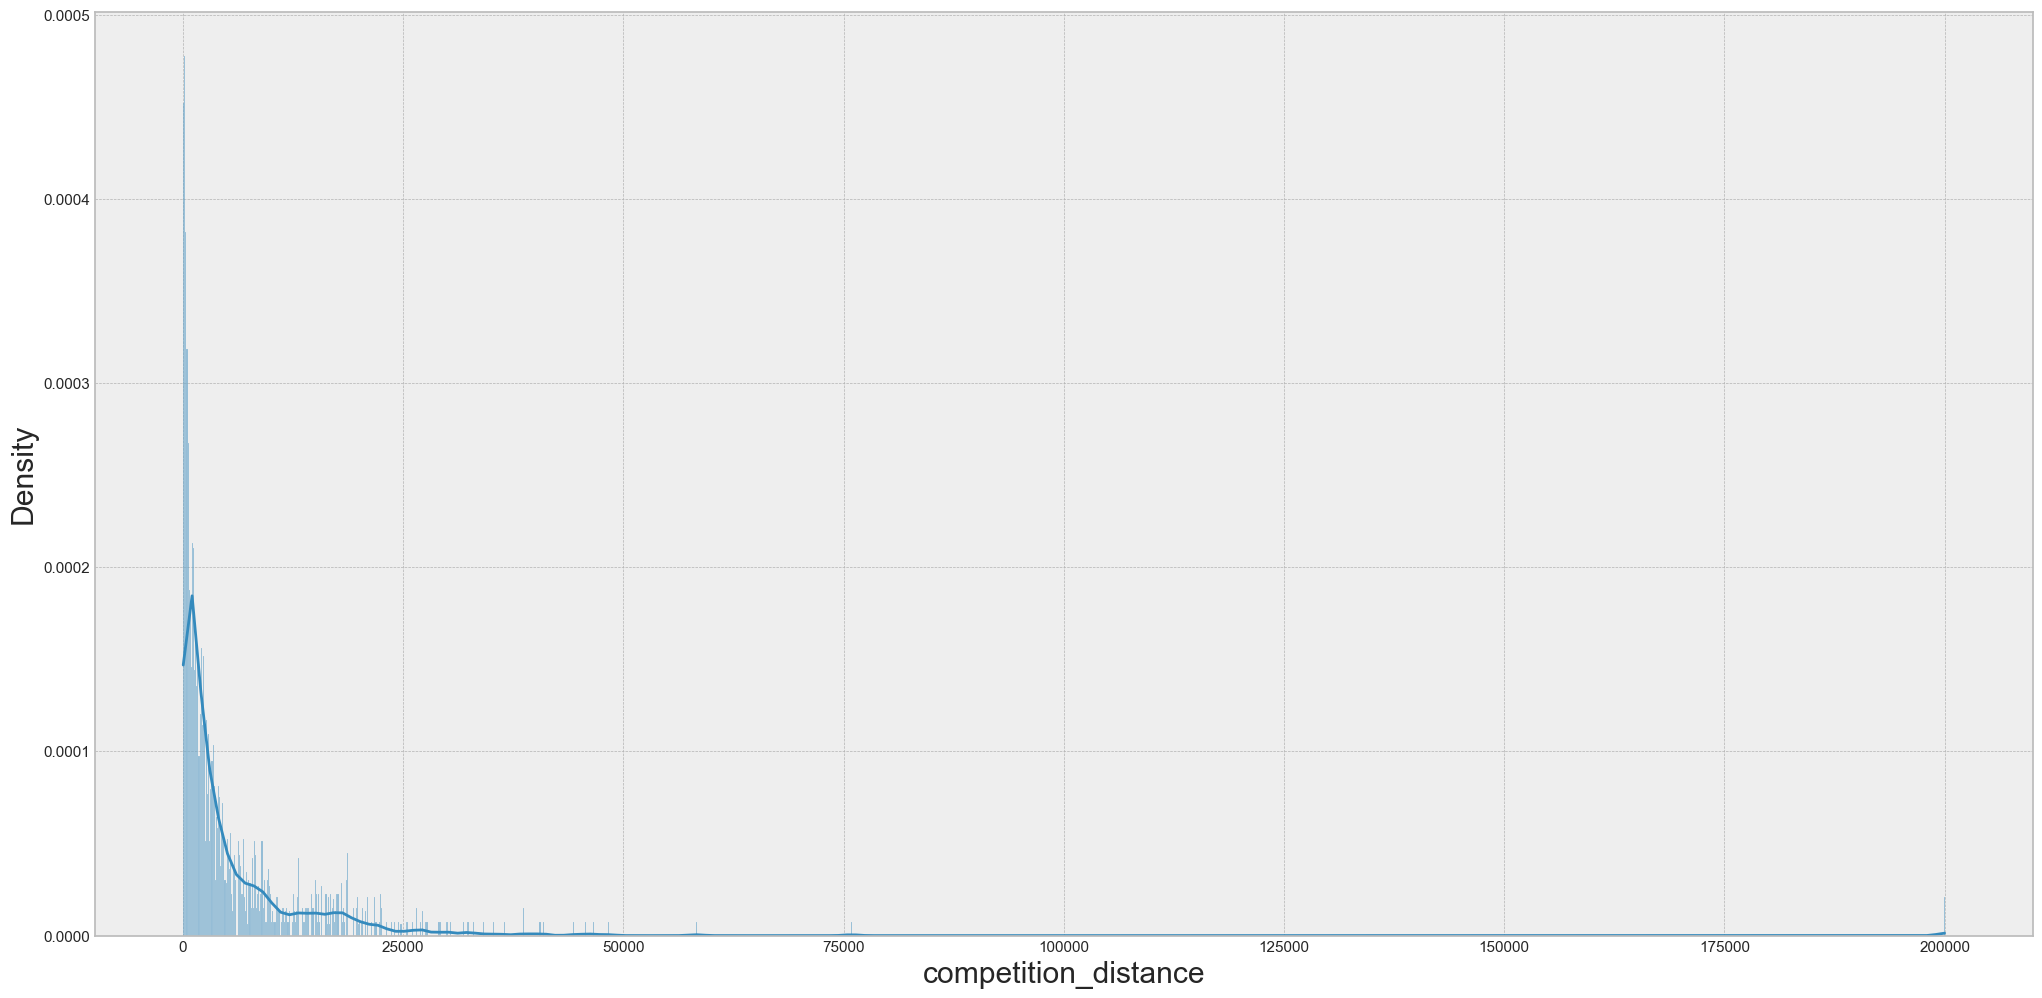

In [16]:
sns.histplot(df1['competition_distance'], kde=True, stat="density")

### 1.7.2 Categoric Atrributes

<AxesSubplot:xlabel='assortment', ylabel='sales'>

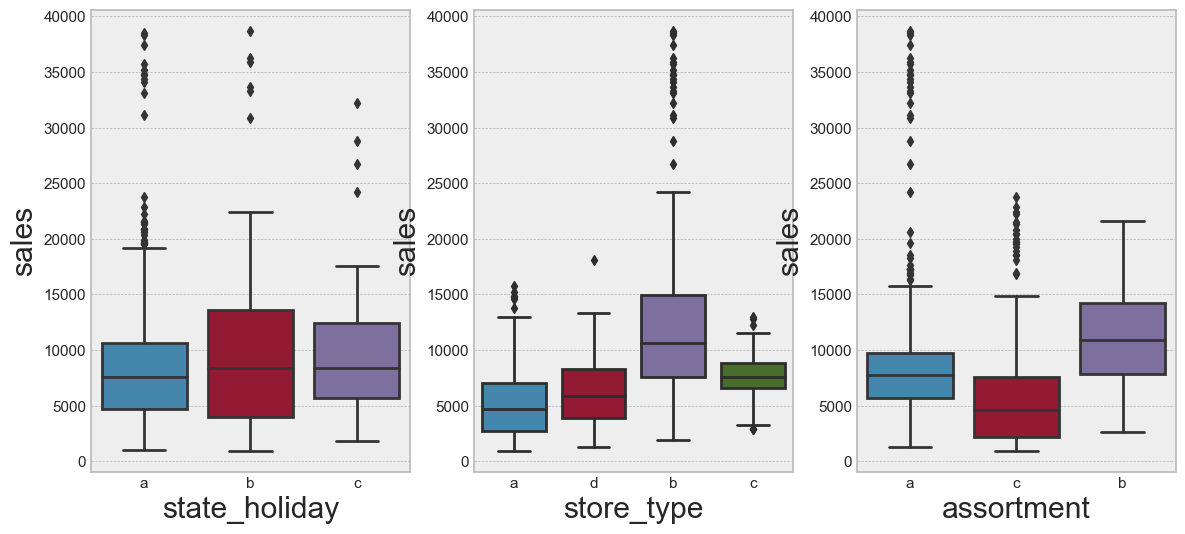

In [17]:
aux1= df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.figure (figsize = (14,6))
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)
plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)
plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# 2.0 Feature Enginnering


In [18]:
df2 = df1.copy()

## 2.1 Mind Map Hypotheses

In [19]:
Image('mindmaphipoteses.png',width=700, height=100)

FileNotFoundError: No such file or directory: 'mindmaphipoteses.png'

FileNotFoundError: No such file or directory: 'mindmaphipoteses.png'

<IPython.core.display.Image object>

## 2.1.1 Store Hypothesis

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

**7.** Lojas com competidores mais proximos deveriam vender menos.

## 2.1.2 Products Hypothesis 

**1.** Lojas que investe mais em marketing deveriam vender mais.

**2.** Lojas que expoe mais produtos expostos na vitrine deveriam vender mais.

**3.** Lojas que tem precos menores em produtos deveriam vender mais.

**4.** Lojas que tem precos menores por mais tempo deveriam vender mais.

**5.** Lojas com promocoes mais agressivas(desconstos maiores) deveriam vender mais.

**6.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais promocoes consecutivas deveriam vender mais.

**8.** Lojas com mais dias de promocoes deveriam vender mais.



## 2.1.2 Time Hypothesis 

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

**4.** Lojas que abrem durante o feriado de natal deveriam vender mais.

**5.** Lojas deveriam vender mais a cada ano.

**6.** Lojas deveriam vender mais no segundo semestre do ano.

**7.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**8.** Lojas deveriam vender menos nos finais de semana.

**9.** Lojas deveriam vender menos durante as ferias escolares.





## 2.2 Final List of Hypotheses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores a mais tempo deveriam vender mais.

**3.** Lojas com competidores mais proximos deveriam vender menos.

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais promocoes consecutivas deveriam vender mais.

**6.** Lojas com mais dias de promocoes deveriam vender mais.

**7.** Lojas que abrem no feriado de natal deveriam mais.

**8.** Lojas que tem precos menores em produtos deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo do ano.

**10.** Lojas com promocoes mais agressivas(desconstos maiores) deveriam vender mais.

**11.** Lojas deveriam vender mais após o dia 10 de cada mes.

**12.** Lojas deveriam vender menos nos finais de semana.

**13.** Lojas deveriam vender menos durante o feriado escolar



## 2.3 Feature Enginnering

In [20]:
df2['year']=df2['date'].dt.year
df2['month']=df2['date'].dt.month
df2['day']=df2['date'].dt.day
df2['week_of_year']=df2['date'].dt.weekofyear
df2['year_of_week']=df2['date'].dt.strftime('%Y-%W')

C:\Users\wesle\AppData\Local\Temp\ipykernel_8984\241576499.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year']=df2['date'].dt.weekofyear


In [21]:
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'],day=1),axis = 1)
df2['competition_since'] = pd.to_datetime(df2['competition_since'], errors = 'coerce')
df2.dropna(inplace=True)
df2['competition_time_month']= ((df2['date'] - df2['competition_since']) /30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%M-%w') - datetime.timedelta(days=7))
# essa nova feature vai armazenar o tempo da promo, se ela estiver negativa significa que está na promo tradicional, se positiva promo é extendida
df2['promo_time_week']= ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

#assortments
df2['assortment']= df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extend')

#state_holiday
df2['state_holiday']=df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 Variables Filtering

In [22]:
df3 = df2.copy()

## 3.1 Rows Filtering

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [24]:
cols_drop = ['customers', 'open','promo_interval', 'month_map']
df3 = df3.drop(cols_drop,axis=1)

# 4.0 Exploratory Data Analysis

In [25]:
df4 = df3.copy()

## 4.1 Univariate Analysis


### 4.1.1 Response variable

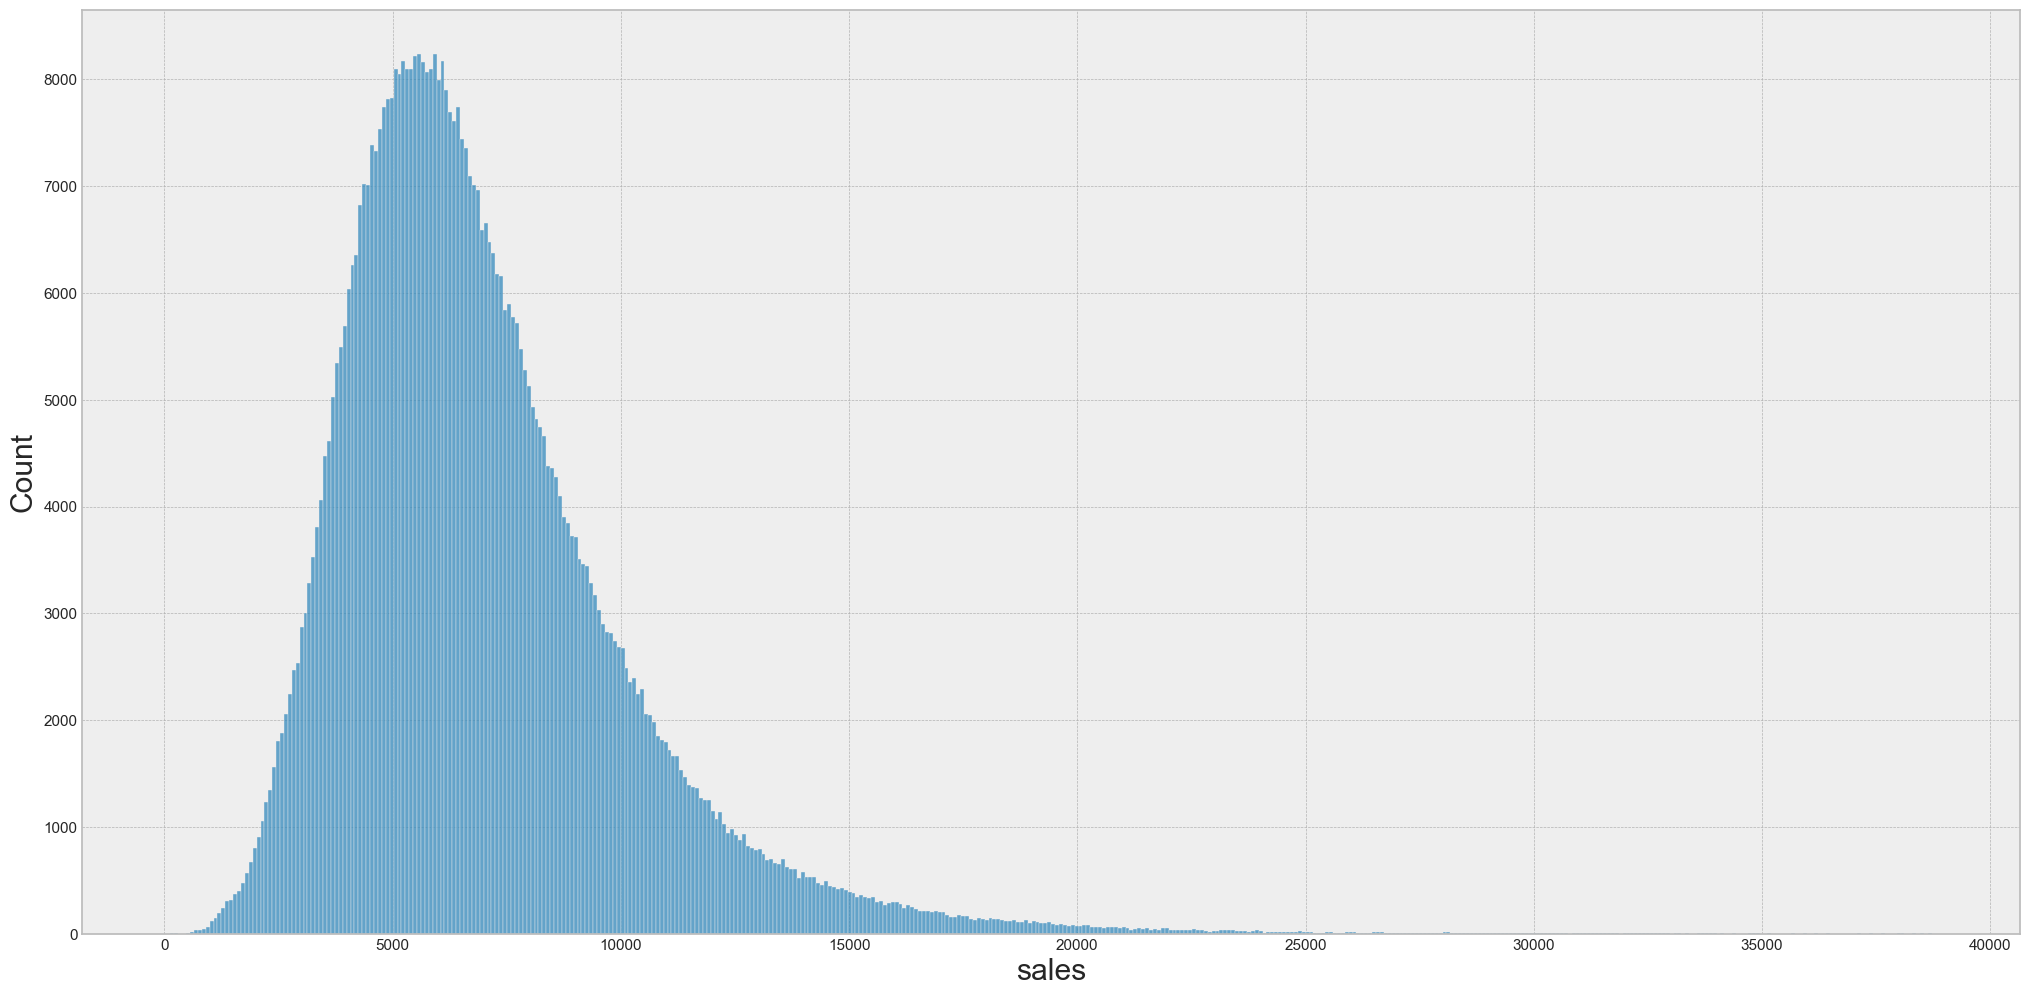

In [26]:
sns.histplot(df4['sales'],kde=False);

### 4.1.2 Numerical variable

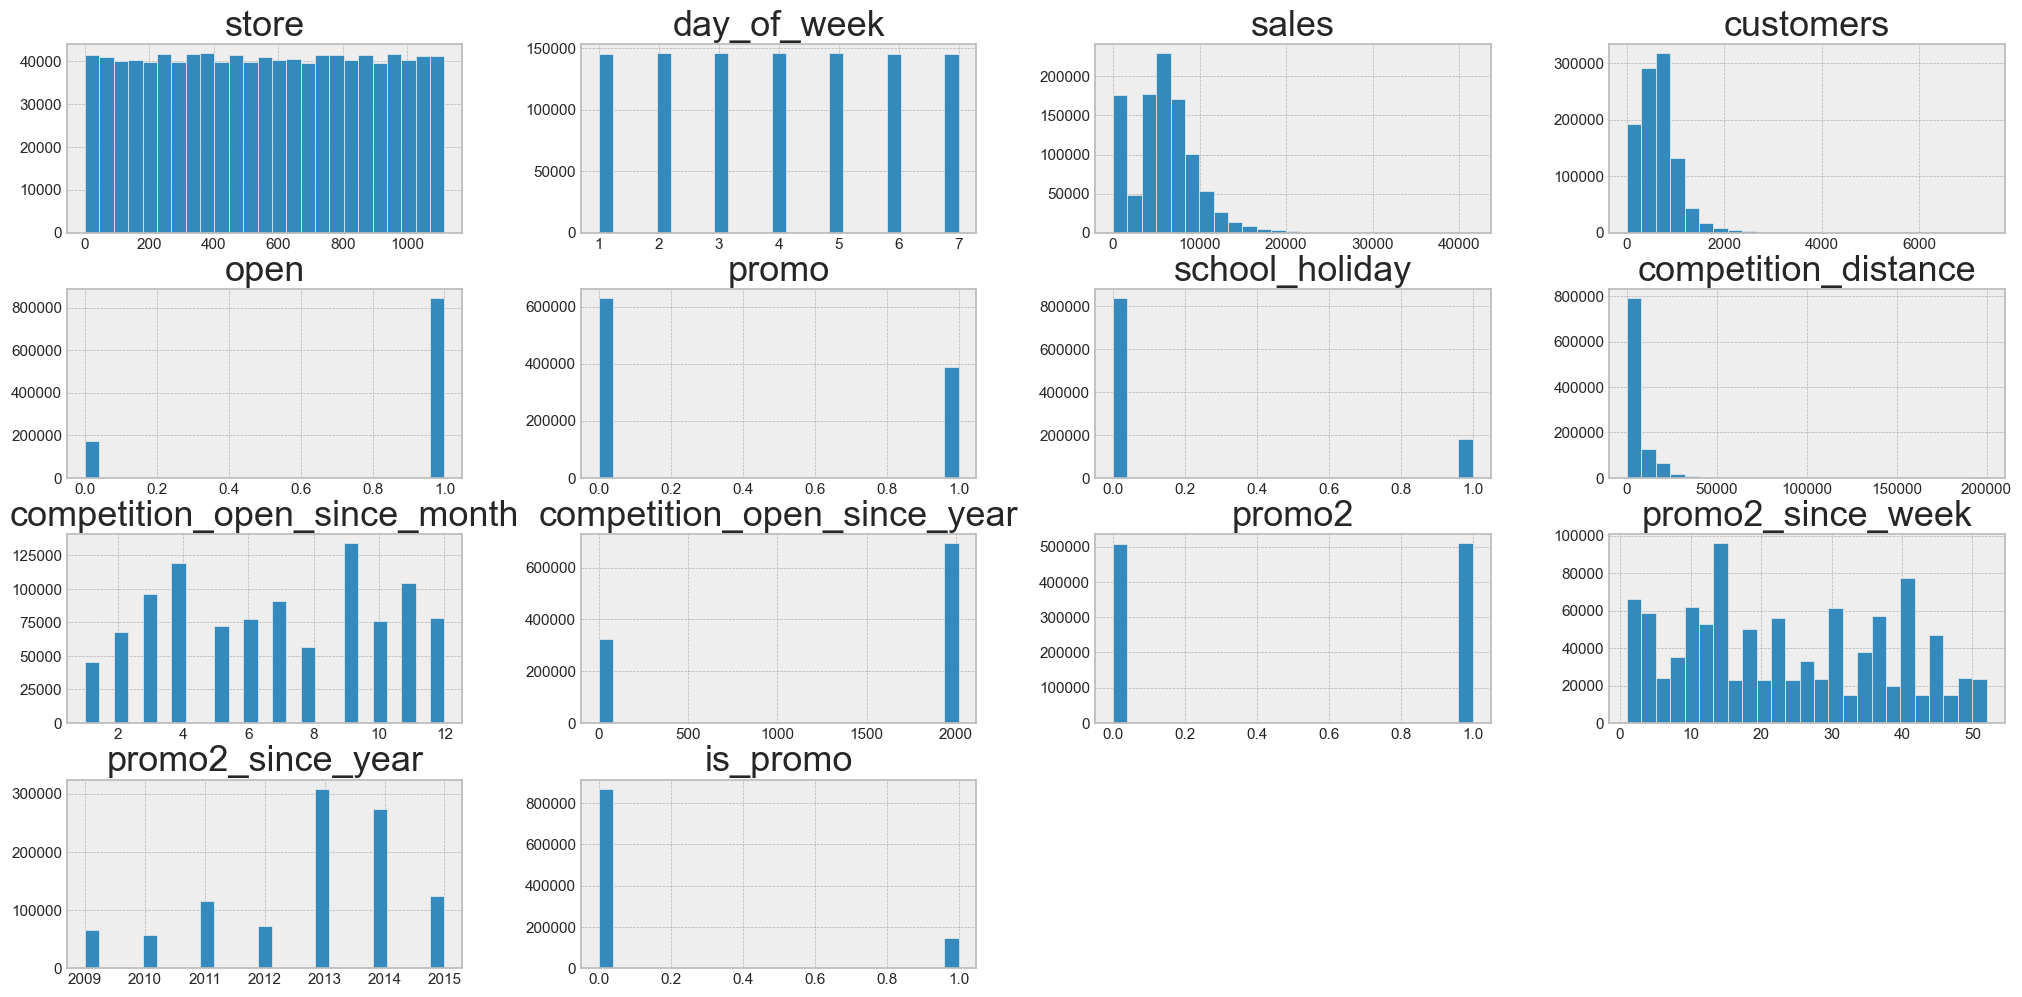

In [27]:
num_attributes.hist(bins= 25);

### 4.1.1 Categorical variable

In [28]:
df4['assortment'].drop_duplicates()


0       basic
3      extend
675     extra
Name: assortment, dtype: object

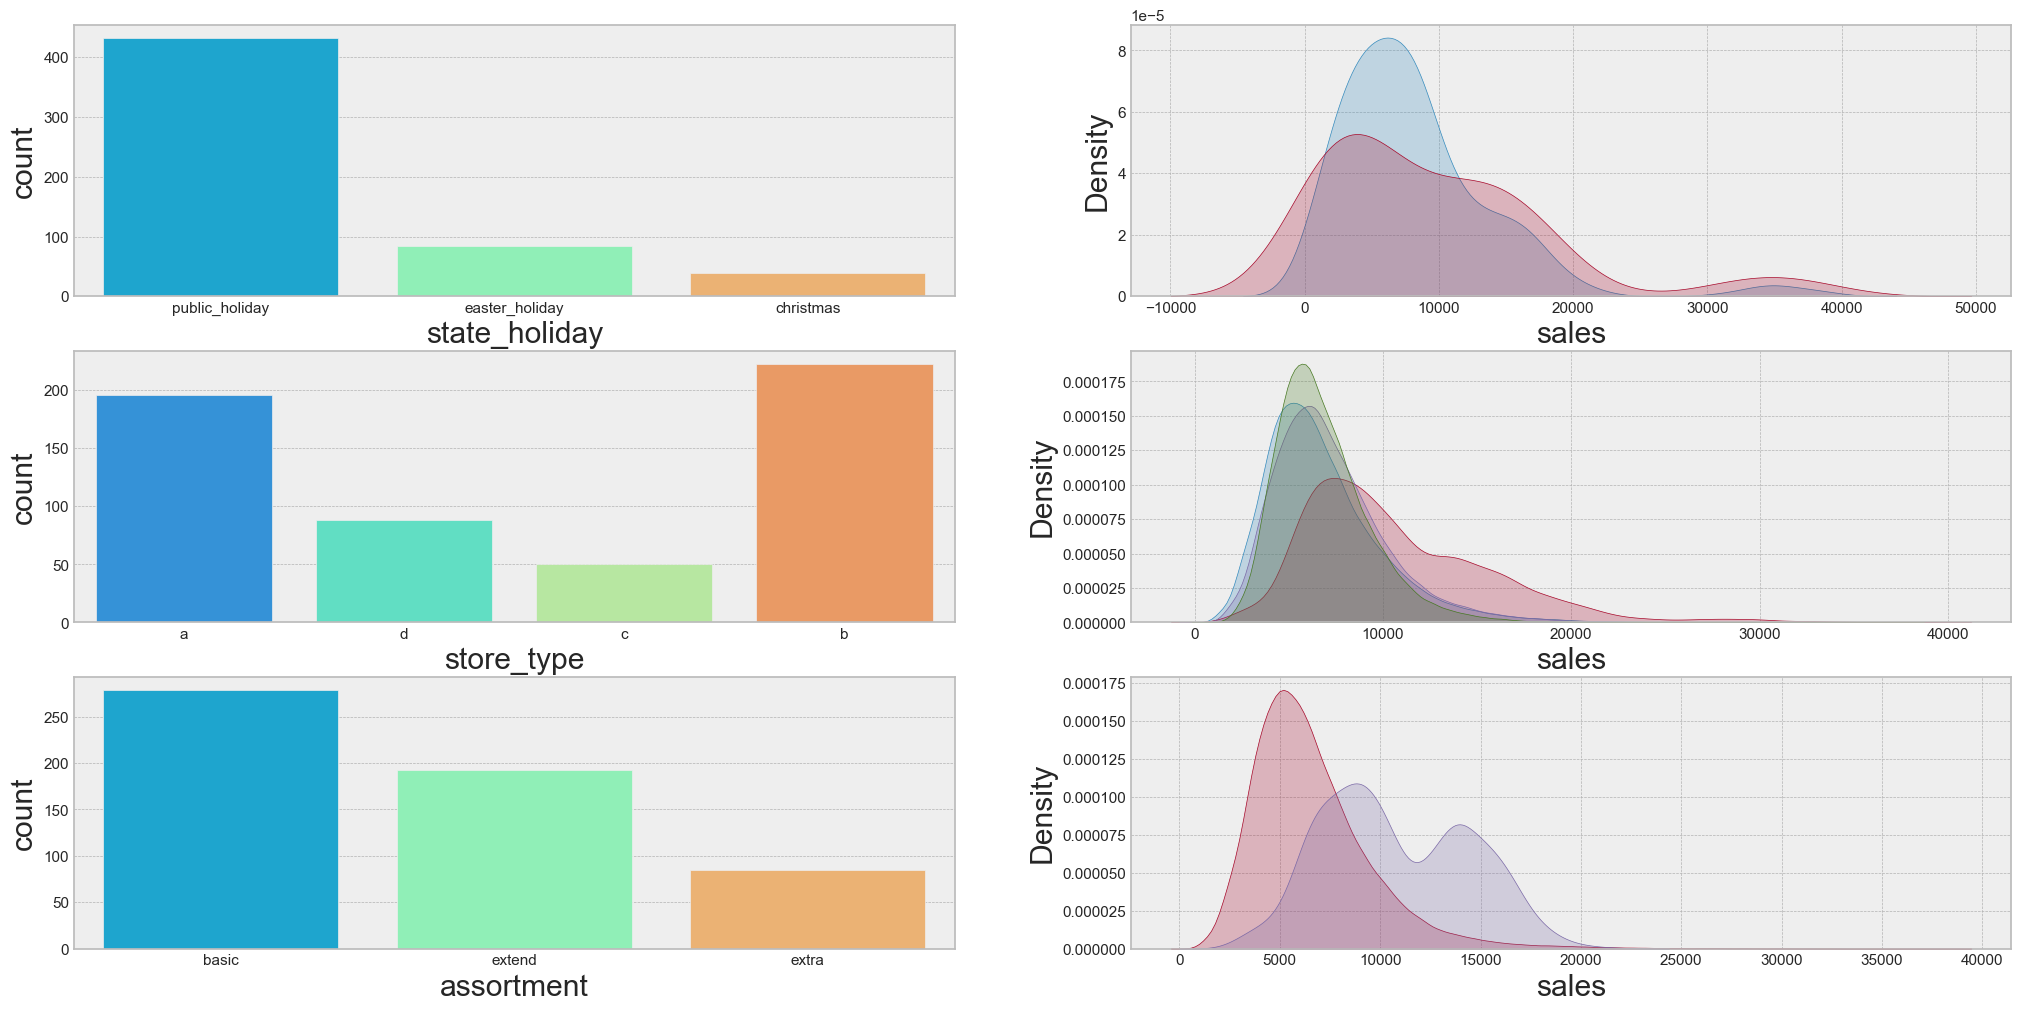

In [29]:
#state holiday
plt.subplot(3,2,1)
a= df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday',data=a, palette='rainbow');
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']== 'public_holiday']['sales'],label='public_holiday',fill=True);
sns.kdeplot(df4[df4['state_holiday']== 'easter_holiday']['sales'],label='easter_holiday',fill=True);
sns.kdeplot(df4[df4['state_holiday']== 'christimas']['sales'],label='christimas',fill=True);

# store_type
plt.subplot(3,2,3)
sns.countplot(x='store_type',data=a, palette='rainbow');
plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']== 'a']['sales'],label='a',fill=True);
sns.kdeplot(df4[df4['store_type']== 'b']['sales'],label='b',fill=True);
sns.kdeplot(df4[df4['store_type']== 'c']['sales'],label='c',fill=True);
sns.kdeplot(df4[df4['store_type']== 'd']['sales'],label='d',fill=True);

# assortments
plt.subplot(3,2,5)
sns.countplot(x='assortment',data=a, palette='rainbow');
plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']== 'extended']['sales'],label='extended',fill=True);
sns.kdeplot(df4[df4['assortment']== 'basic']['sales'],label='basic',fill=True);
sns.kdeplot(df4[df4['assortment']== 'extra']['sales'],label='extra',fill=True);


## 4.2 Bivariate Analysis


### H**1.** Lojas com maior sortimento deveriam vender mais.
***FALSO** Lojas com MAIOR SORTIMENTOS VENDEM MENOS.

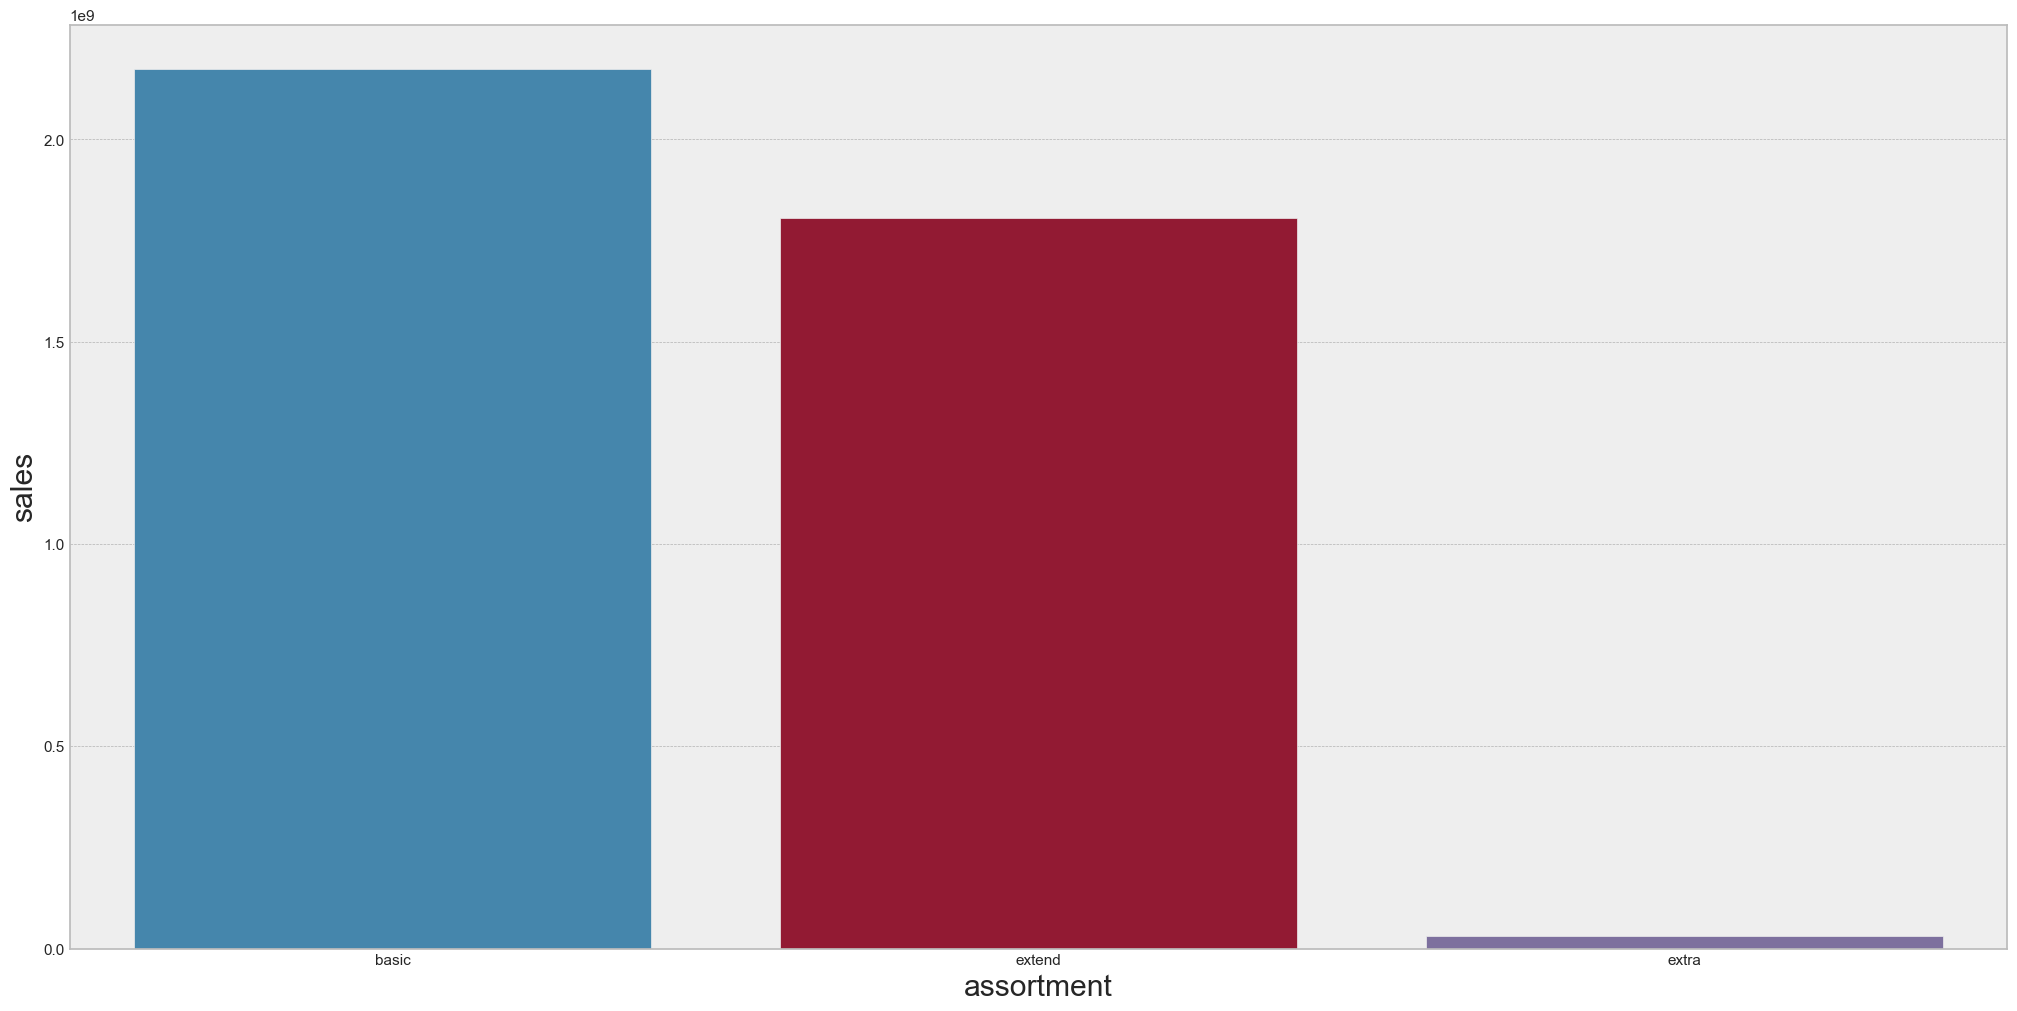

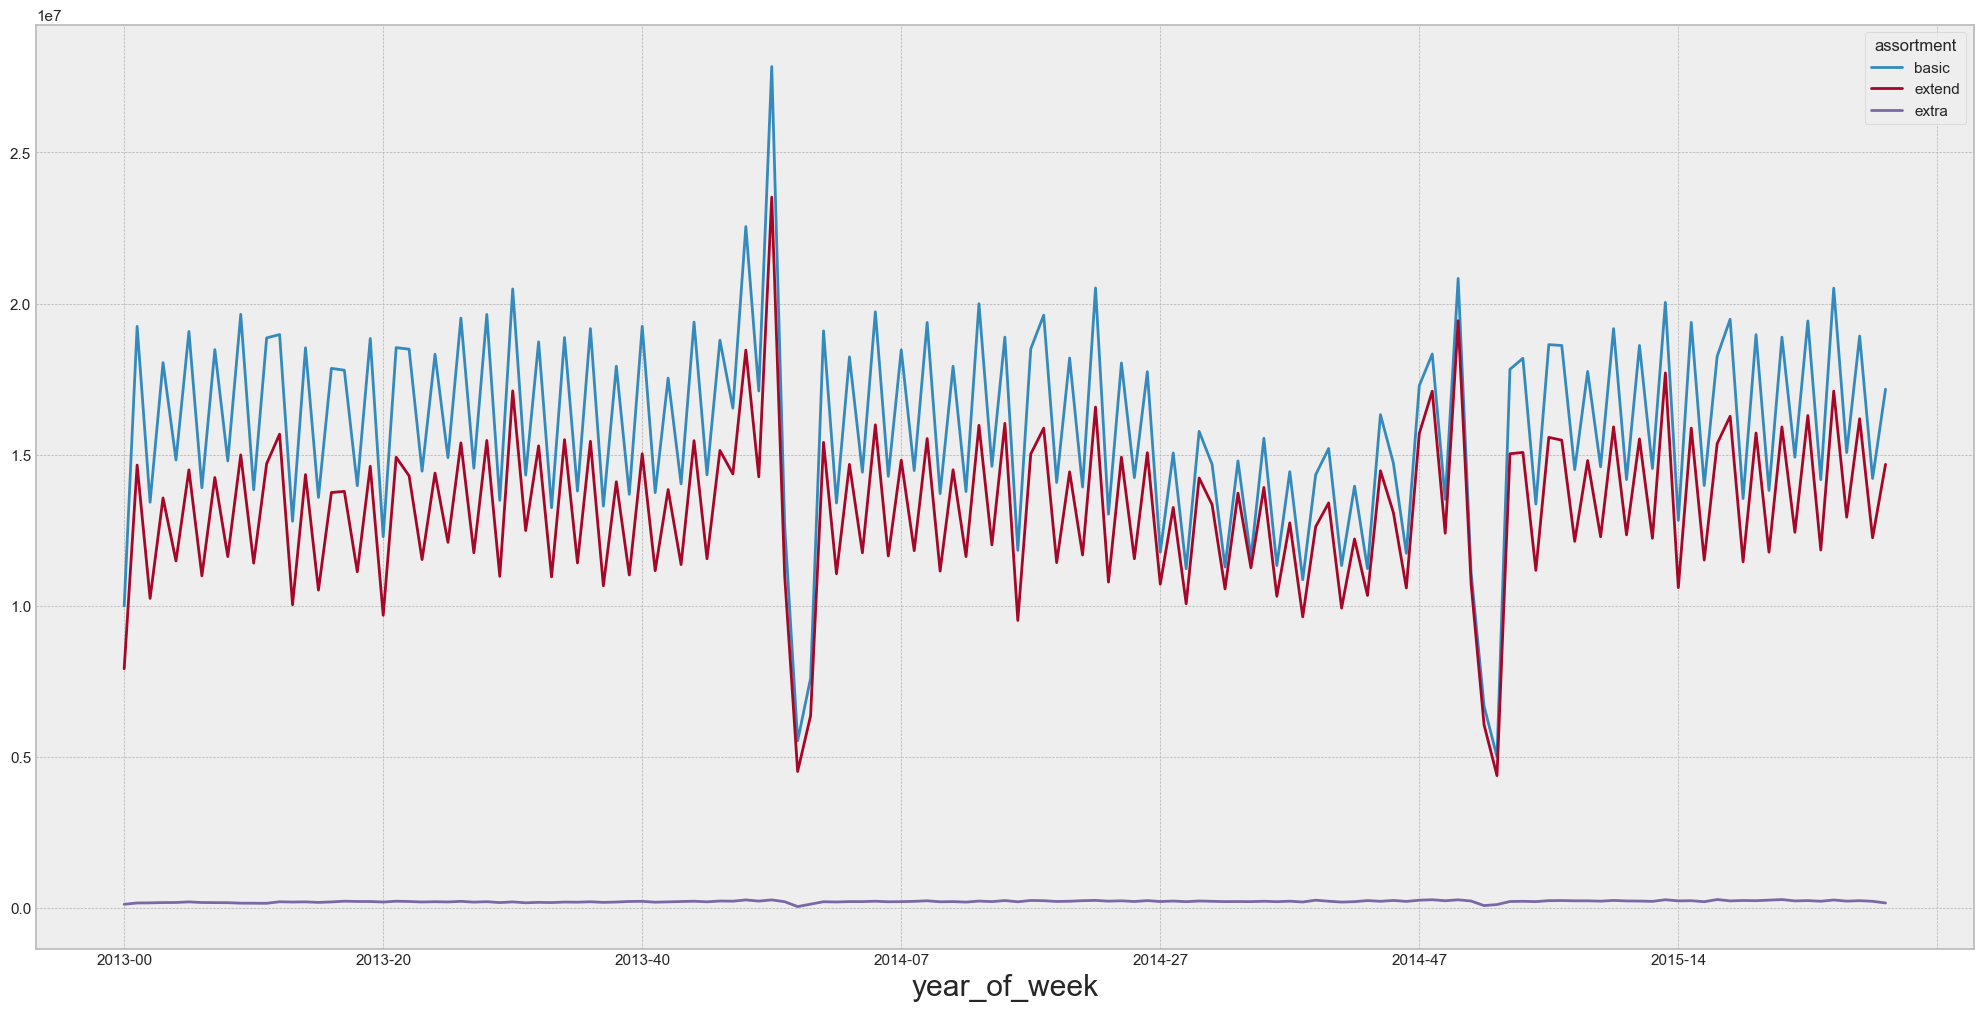

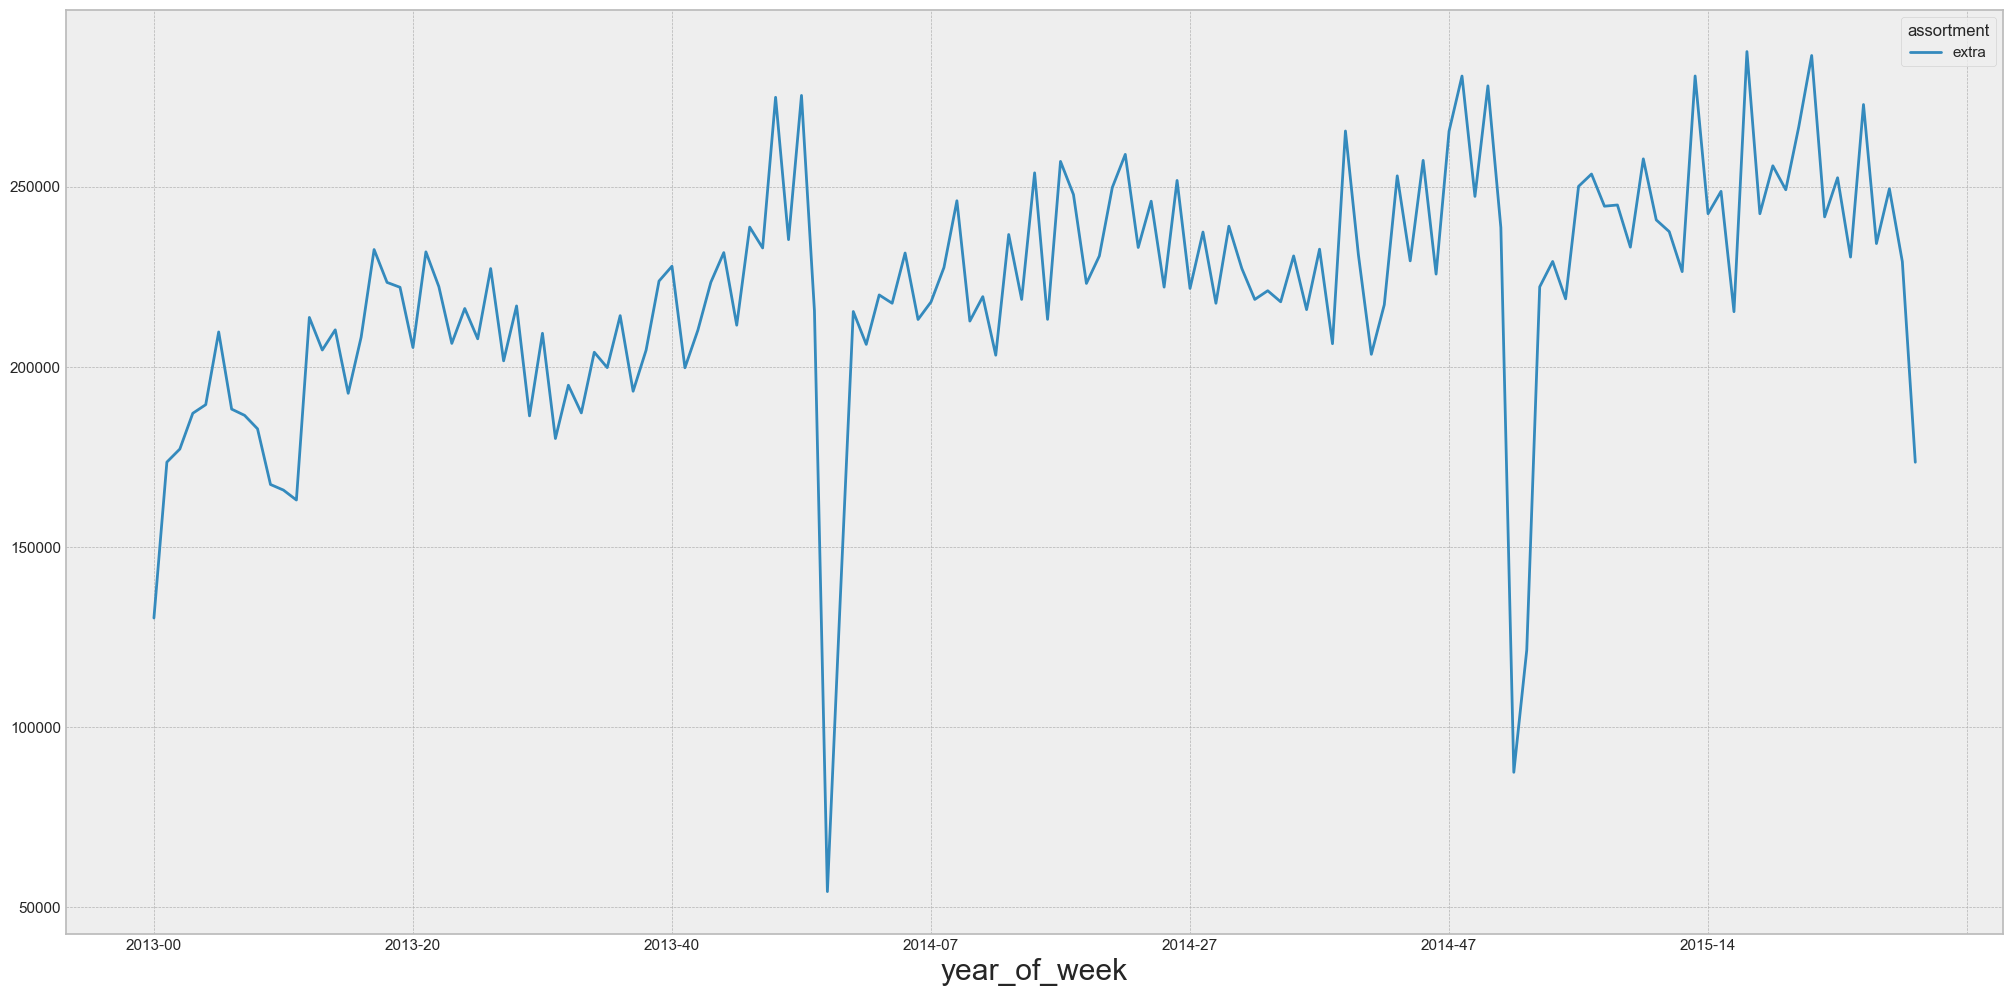

In [30]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data= aux1);

aux2 = df4[['year_of_week','assortment','sales']].groupby(['year_of_week','assortment']).sum().reset_index()
aux2.pivot(index='year_of_week', columns='assortment',values='sales').plot();

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_of_week', columns='assortment',values='sales').plot();


### H**2.** Lojas com competidores a mais tempo deveriam vender mais.
**FALSO** Lojas com COMPETIDORES COM MAIS TEMPO VENDE MENOS


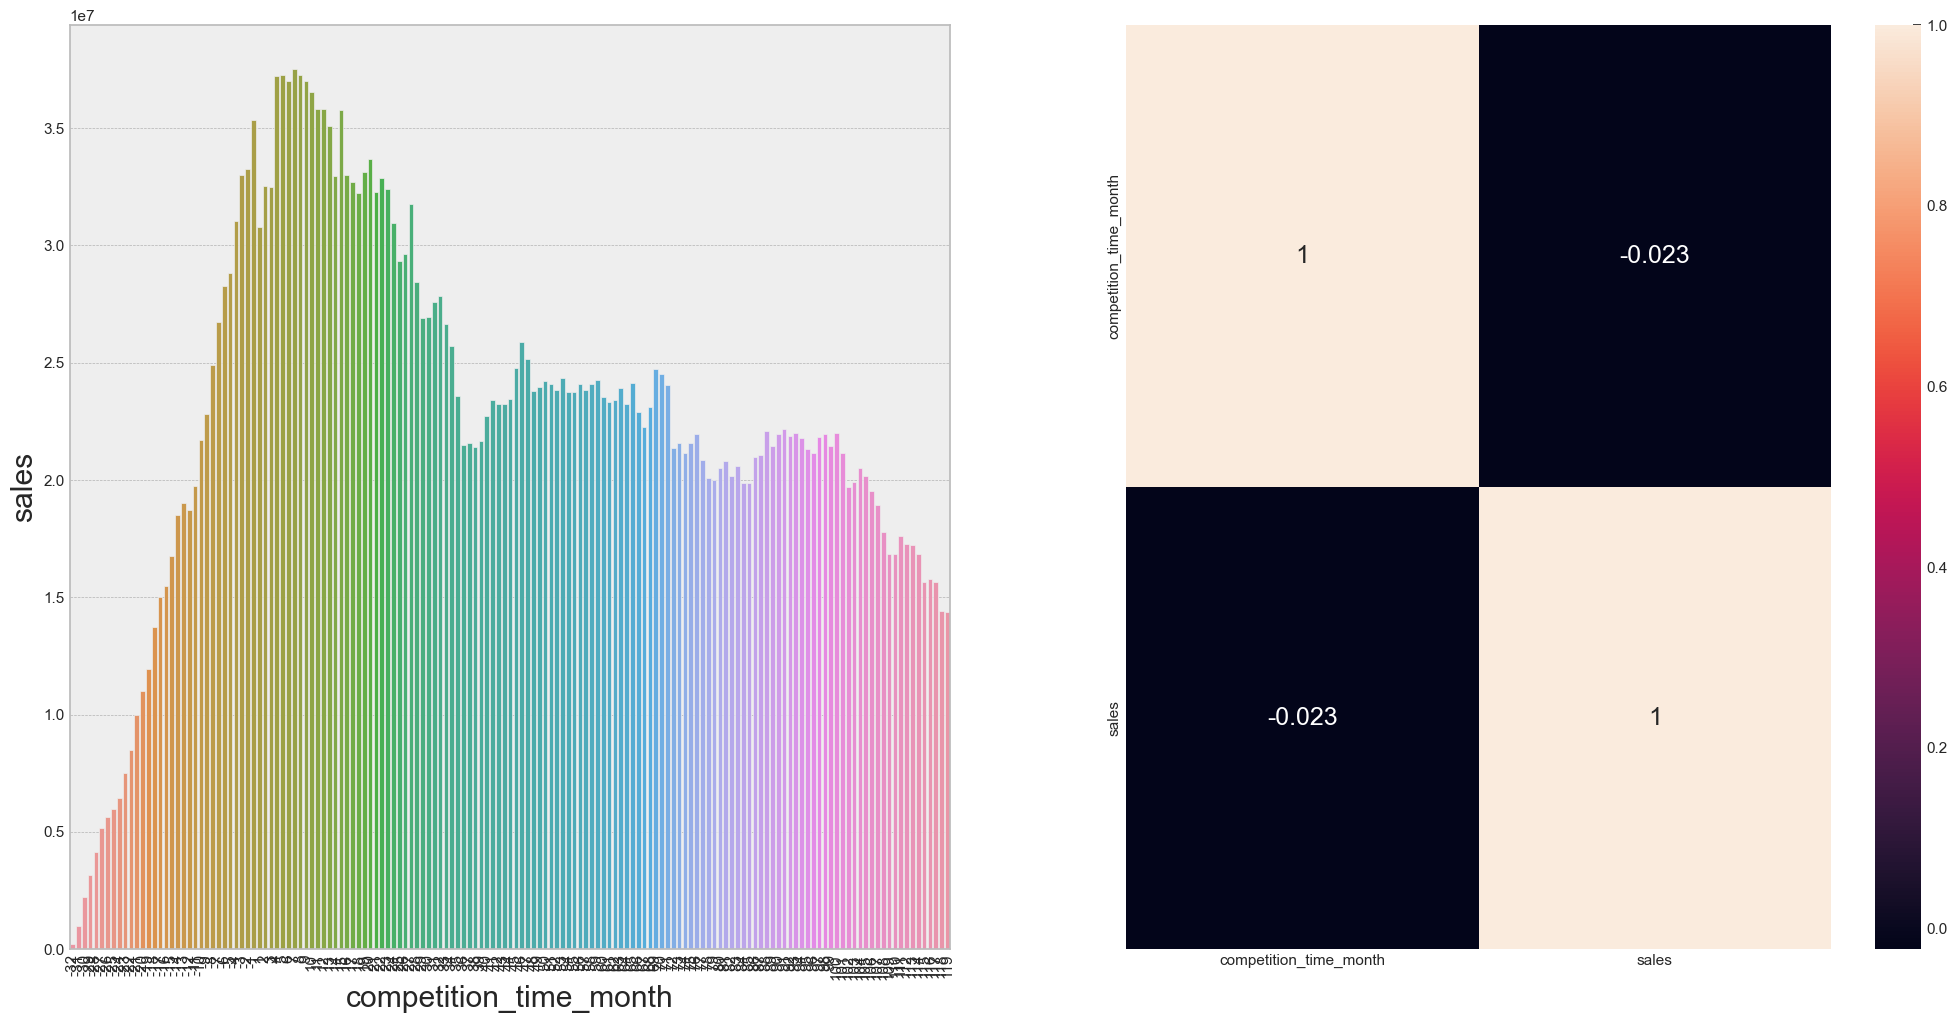

In [31]:
plt.subplot(1,2,1)
aux1= df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2= aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0)]
plt.xticks(rotation=90)
sns.barplot(x='competition_time_month',y='sales',data=aux2);

plt.subplot(1,2,2)
sns.heatmap(aux2.corr(method='pearson'),annot=True);


### H**3.** Lojas com competidores mais proximos deveriam vender menos.
**FALSO** Lojas com COMPETIDORES MAIS PROXIMOS VENDEM MAIS.

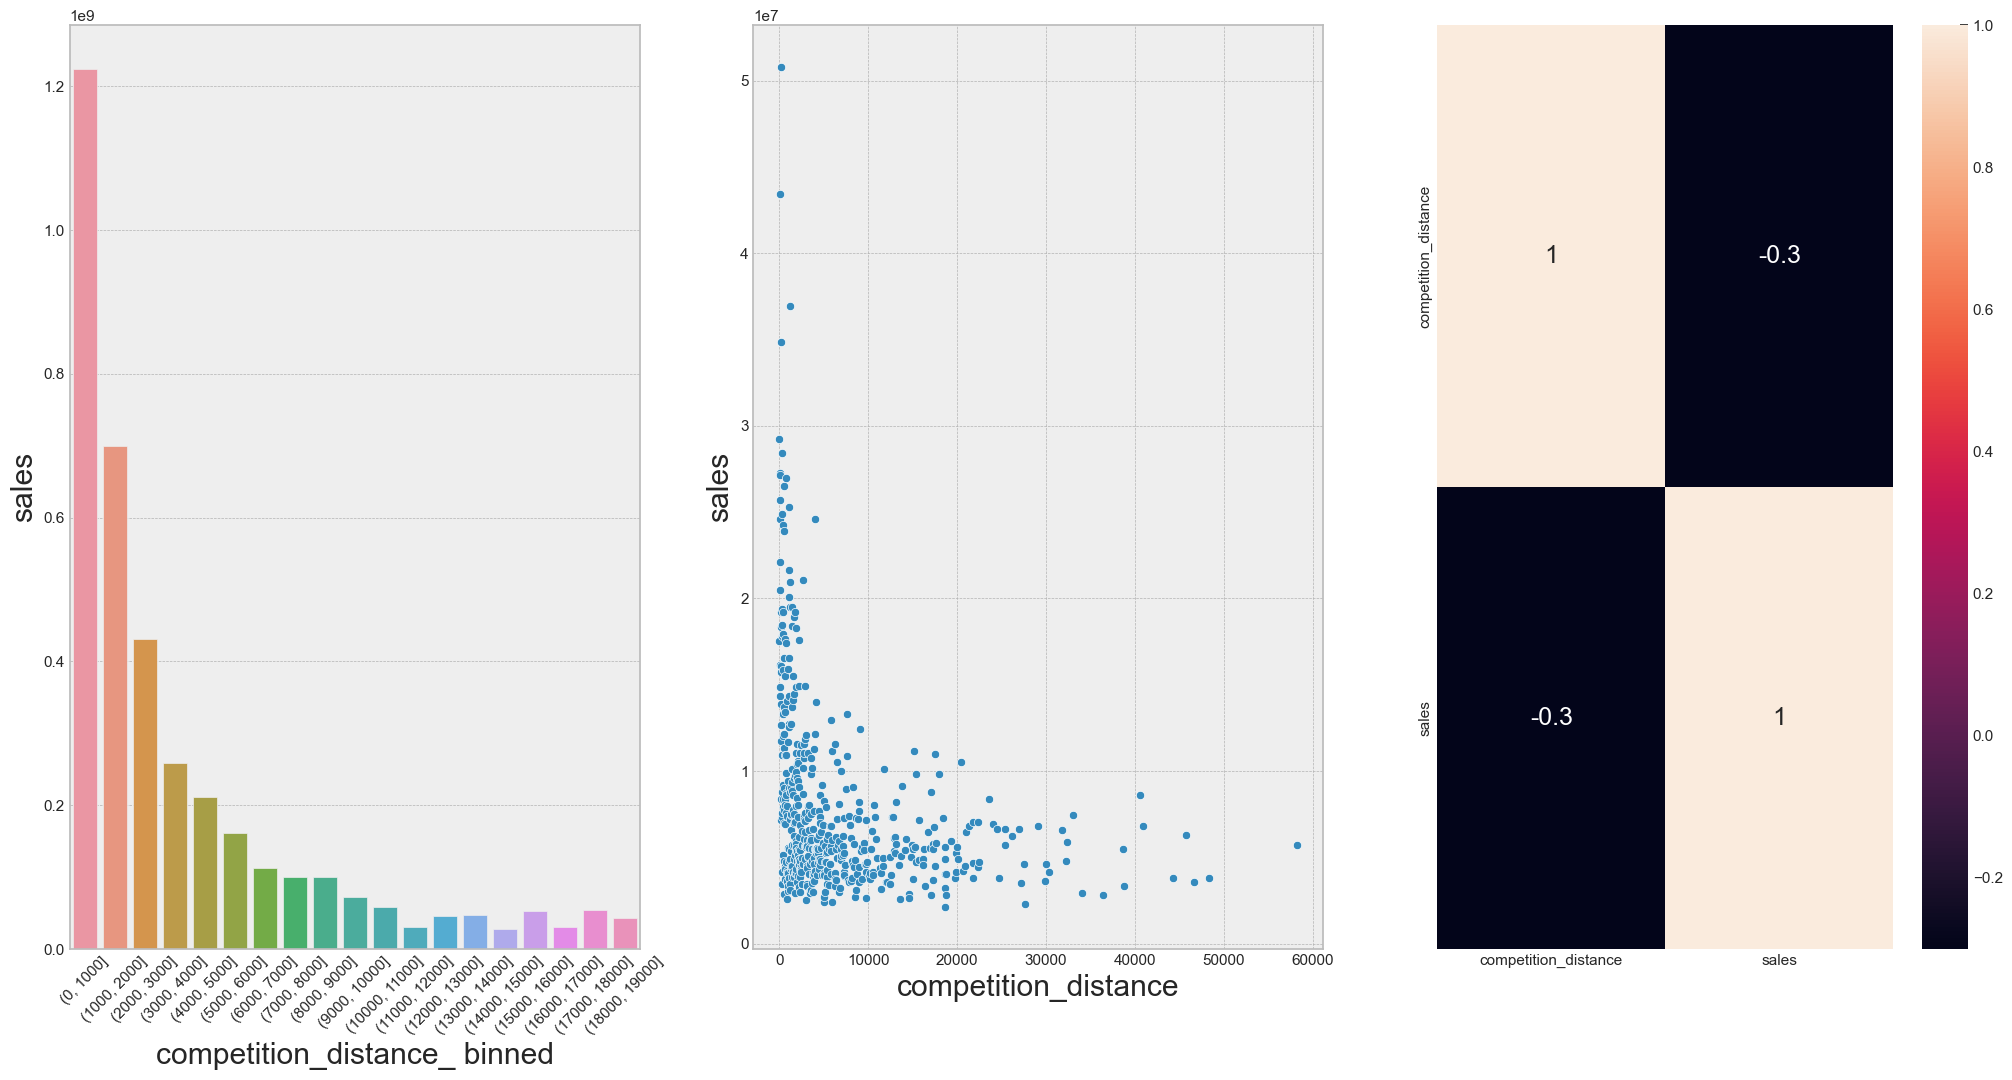

In [32]:
aux1=df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

#criando grupos para melhorar a visualização da plotagem com barplot:

plt.subplot(1,3,1)
bins=list(np.arange(0,20000,1000))

aux1['competition_distance_ binned'] = pd.cut(aux1['competition_distance'],bins=bins)

aux2= aux1[['competition_distance_ binned','sales']].groupby('competition_distance_ binned').sum().reset_index()
plt.xticks(rotation=45)
sns.barplot(x='competition_distance_ binned',y='sales',data=aux2);

# uma outra opção para dados com muita granularidade é fazer plot de distribuição:
plt.subplot(1,3,2)

sns.scatterplot(x='competition_distance',y='sales',data=aux1)

# consultando o impacto de correlação entre as variaveis
#quanto mais próximo de 1 ou -1 mais forte é a relação
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);


### H**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.
**FALSO** lojas com PROMO ATIVA POR MAIS TEMPO VENDE MENOS


<AxesSubplot:>

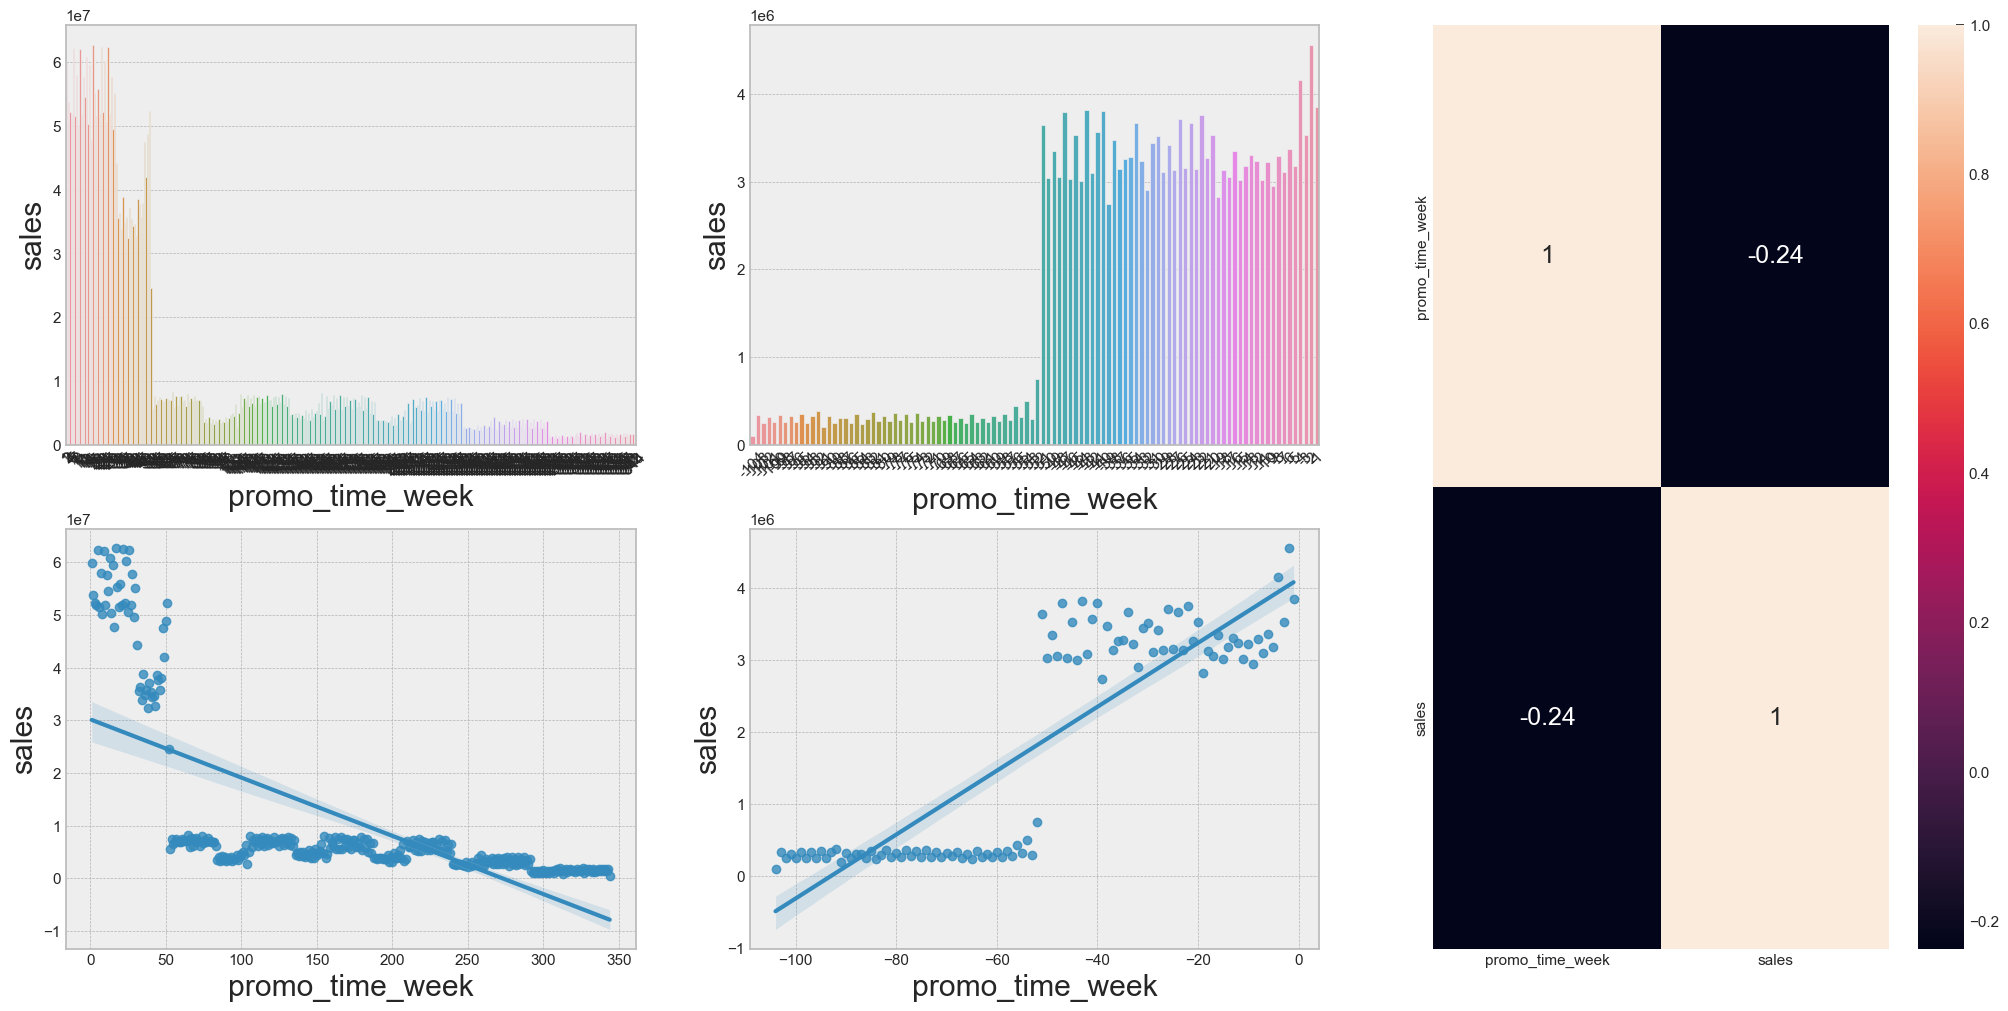

In [33]:
aux1=df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot(x='promo_time_week',y='sales',data=aux1);

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2=aux1[aux1['promo_time_week'] >0] #promo extend
plt.xticks(rotation=45)
sns.barplot(x='promo_time_week',y='sales',data=aux2);

plt.subplot(grid[0,1])
aux3=aux1[aux1['promo_time_week'] <0] #promo regular
plt.xticks(rotation=45)
sns.barplot(x='promo_time_week',y='sales',data=aux3);

plt.subplot(grid[1,0])
sns.regplot(x='promo_time_week',y='sales',data=aux2);


plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### <s>H**5.** Lojas com mais promocoes consecutivas deveriam vender mais.</s>



### H**6.** Lojas com mais dias de promocoes deveriam vender mais.
**FALSO** Lojas com MAIS DIAS de PROMOCOES VENDE MENOS.

In [34]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1076508213
1,0,1,812853512
2,1,0,1183603318
3,1,1,938174628


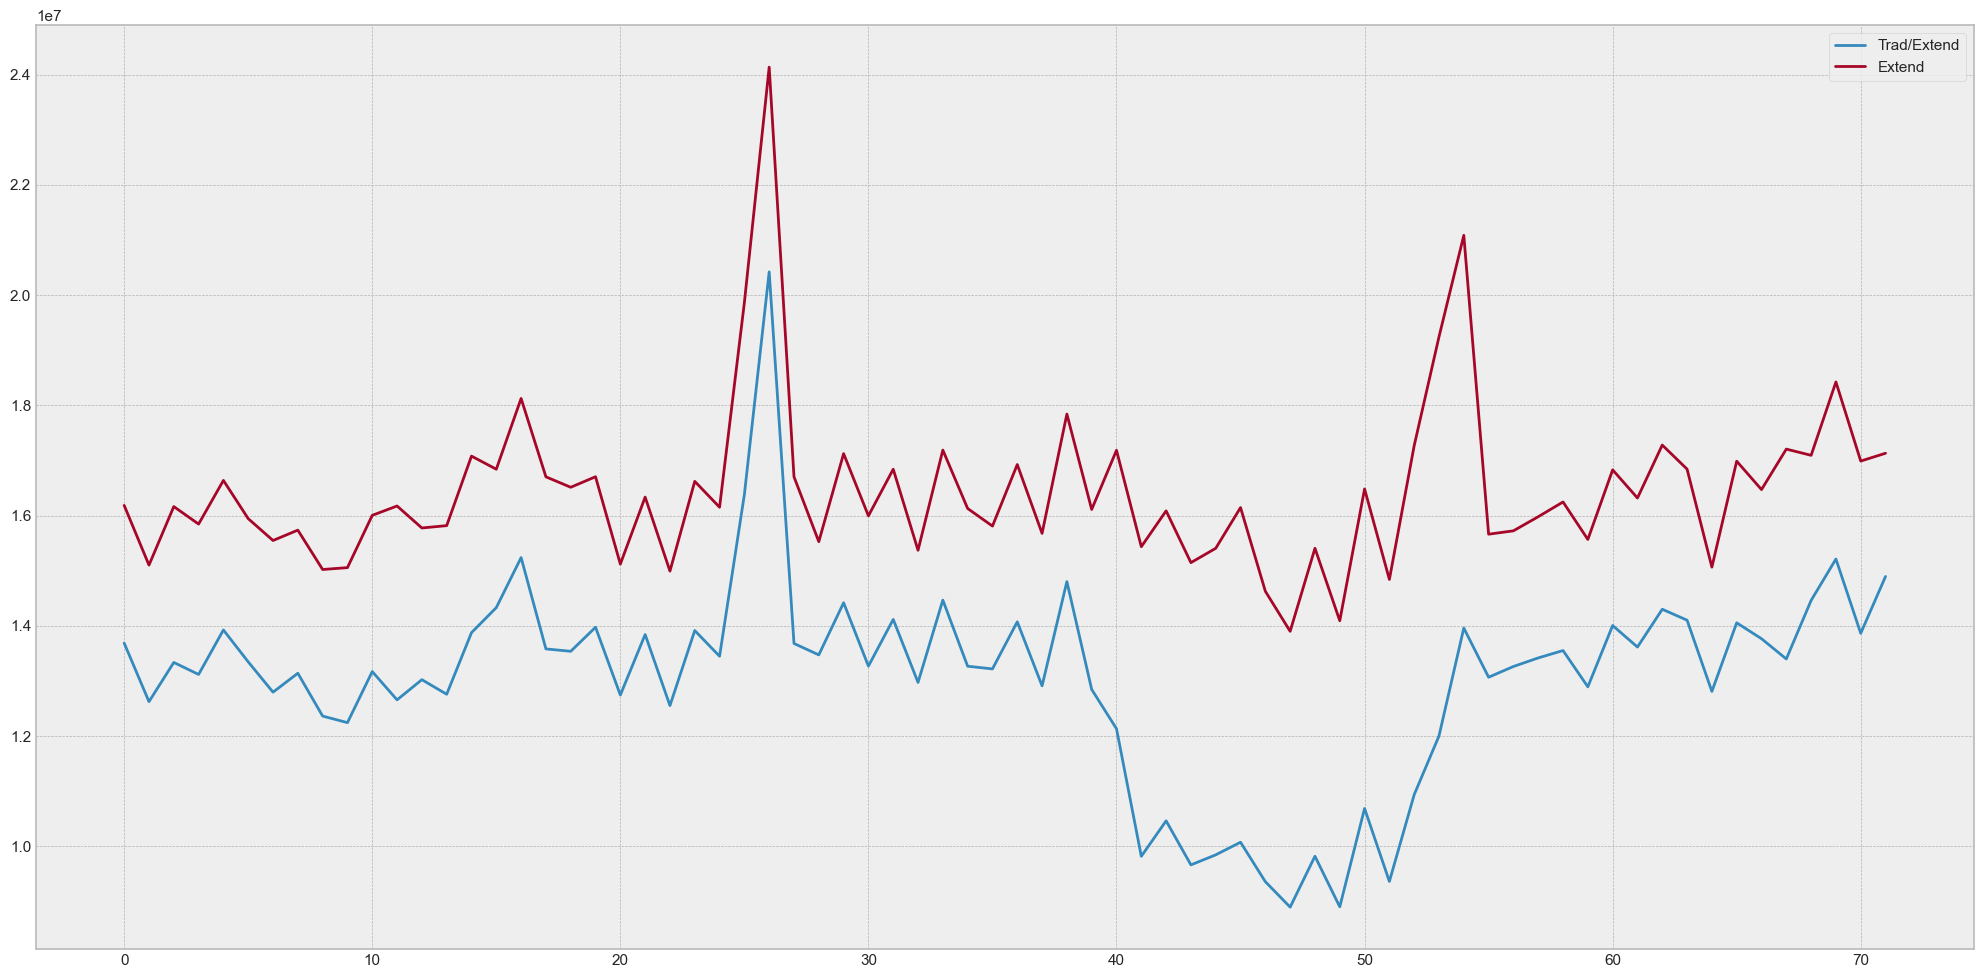

In [35]:
aux1= df4[(df4['promo']==1) & (df4['promo2']==1)][['year_of_week','sales']].groupby('year_of_week').sum().reset_index()
aux = aux1.plot()

aux2= df4[(df4['promo']==1) & (df4['promo2']==0)][['year_of_week','sales']].groupby('year_of_week').sum().reset_index()
aux2.plot(ax=aux);
aux.legend(labels= ['Trad/Extend','Extend']);

### H**7.** Lojas que abrem no feriado de natal deveriam mais.
**FALSO** Lojas que ABREM no NATAL VENDE MENOS.



<AxesSubplot:xlabel='year', ylabel='sales'>

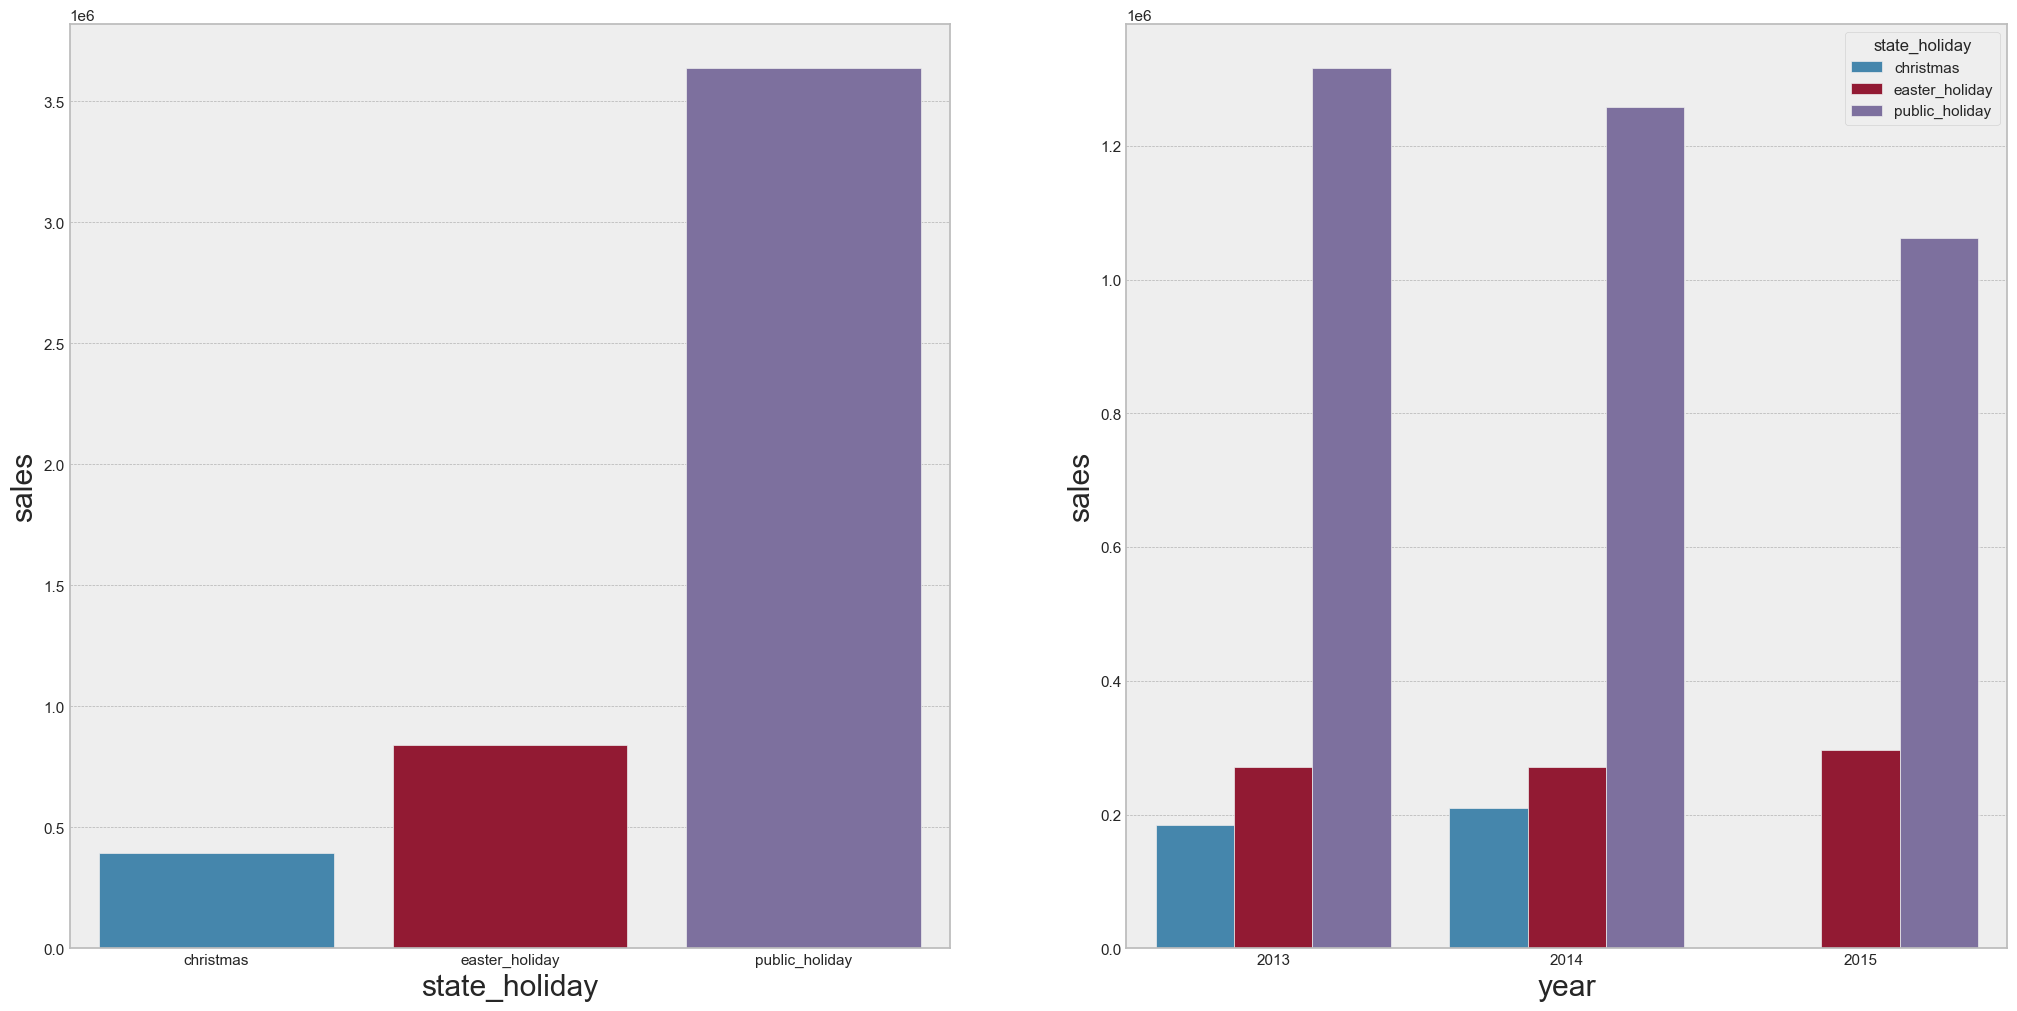

In [36]:
aux=df4[df4['state_holiday']!='regular_day']

plt.subplot(1,2,1)
aux1=aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,2,2)
aux2=aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux2)



In [37]:
df4.head(2)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_of_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2014-12-25 00:31:00,31
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2009-12-25 00:13:00,291


### H**9.** Lojas deveriam vender mais ao longo do ano.
**FALSO** Lojas VENDEM MENOS ao LONGO do ANO.


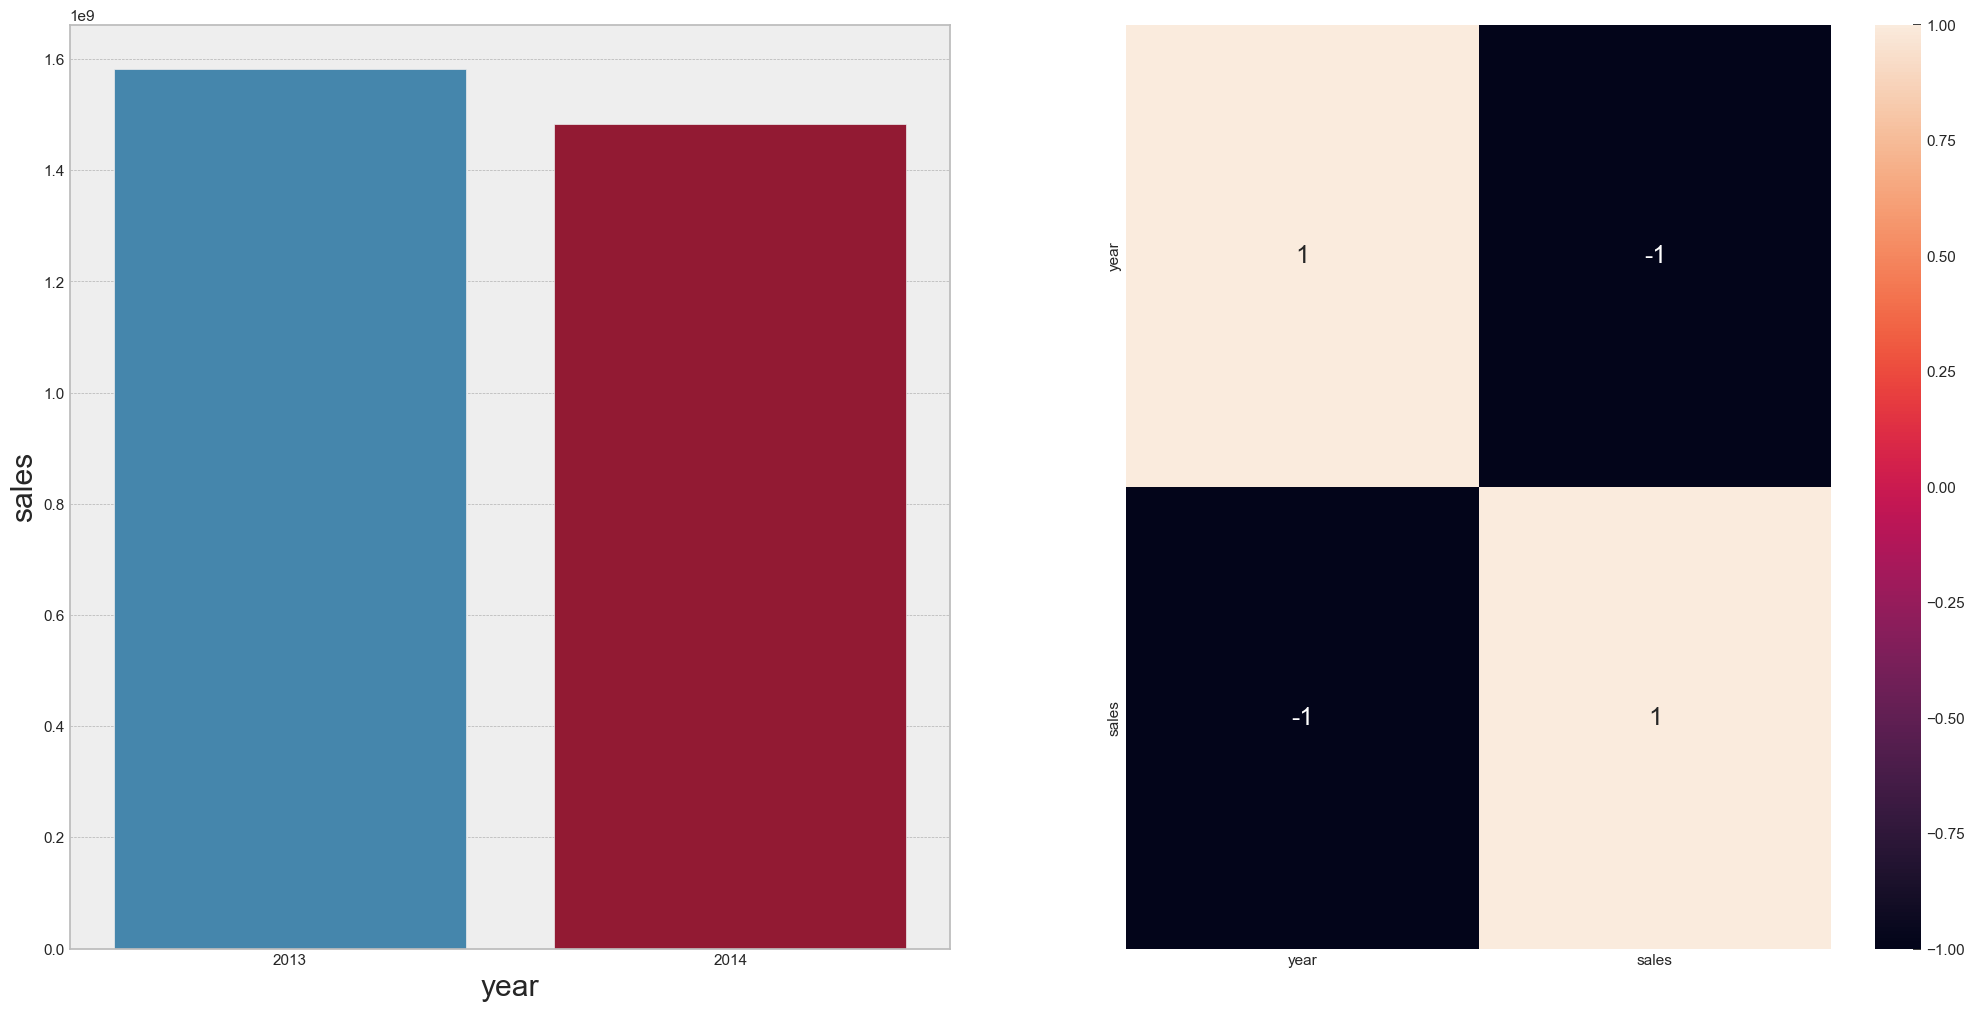

In [38]:
aux = df4[df4['year'] < 2015]
aux1= aux[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x= 'year',y='sales',data=aux1);
plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'),annot=True);


### H**10.** Lojas  deveriam vender mais no segundo semestre do ano
**FALSO** Lojas VENDEM MENOS no SEGUNDO SEMESTRE.

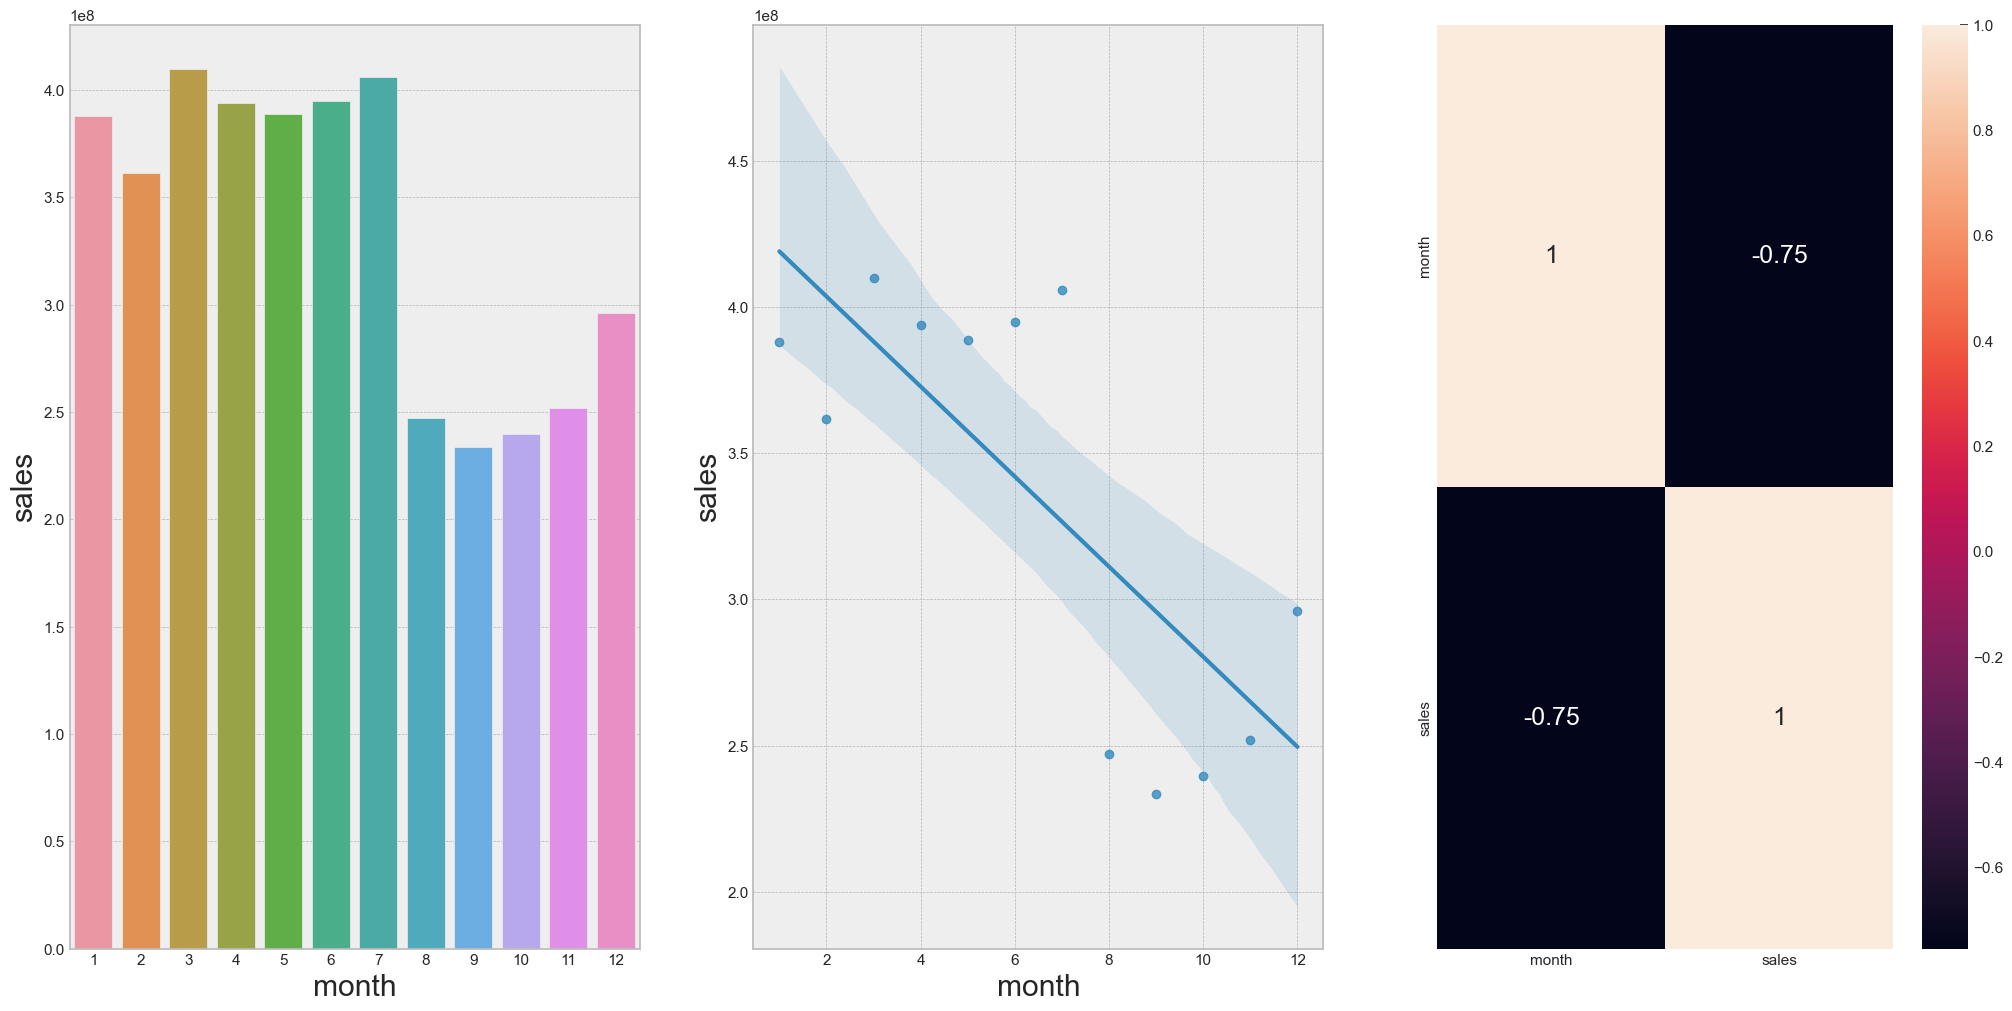

In [39]:
aux1= df4[['month','sales']].groupby('month').sum().reset_index();

plt.subplot(1,3,1)
sns.barplot(x= 'month', y= 'sales', data= aux1);

plt.subplot(1,3,2)
sns.regplot(x= 'month', y= 'sales', data= aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H**11.** Lojas deveriam vender mais após o dia 10 de cada mes.
**VERDADEIRO** Lojas VENDEM MAIS APÒS o DIA 10 de cada mes.

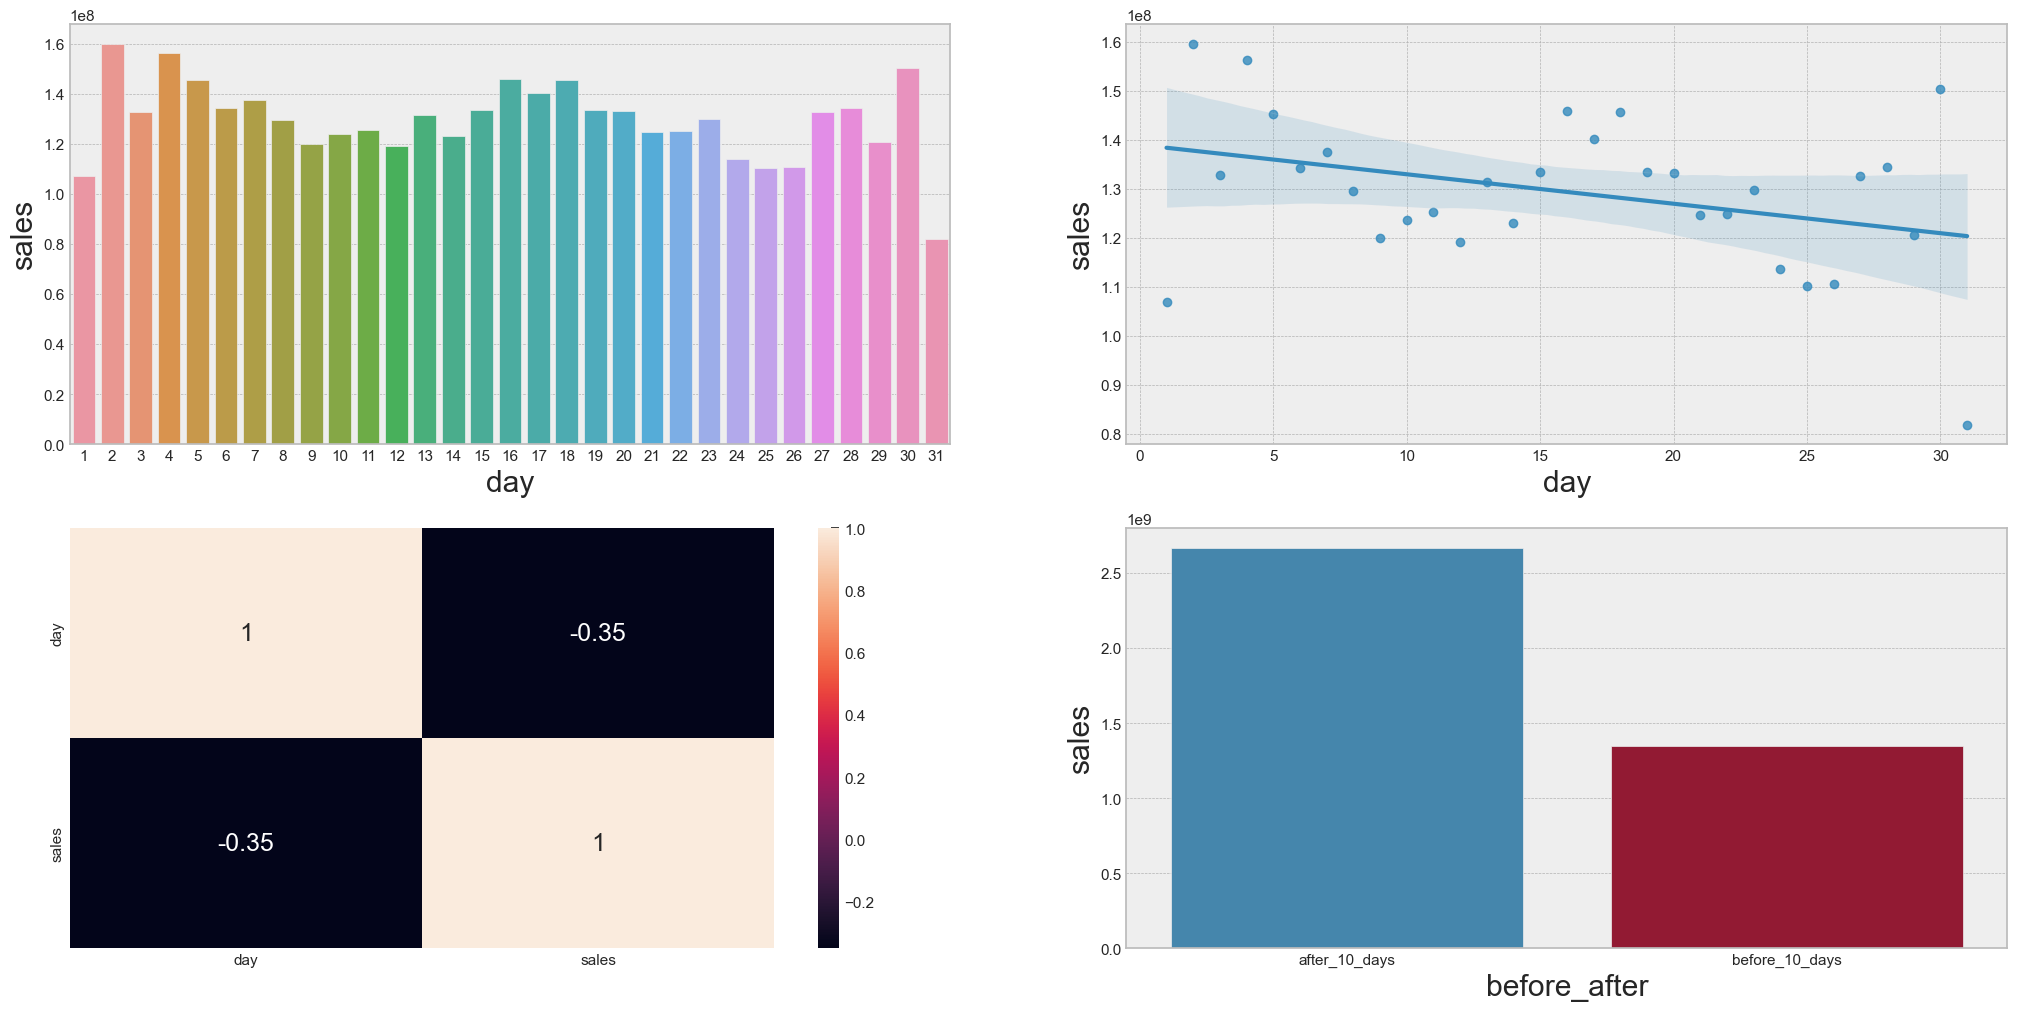

In [40]:
aux1= df4[['day','sales']].groupby('day').sum().reset_index();

plt.subplot(2,2,1)
sns.barplot(x= 'day', y= 'sales', data= aux1);

plt.subplot(2,2,2)
sns.regplot(x= 'day', y= 'sales', data= aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after']= aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data=aux2);

### H**12.** Lojas deveriam vender menos nos finais de semana.
**VERDADEIRO**  Lojas VENDEM MENOS nos finais de semana.


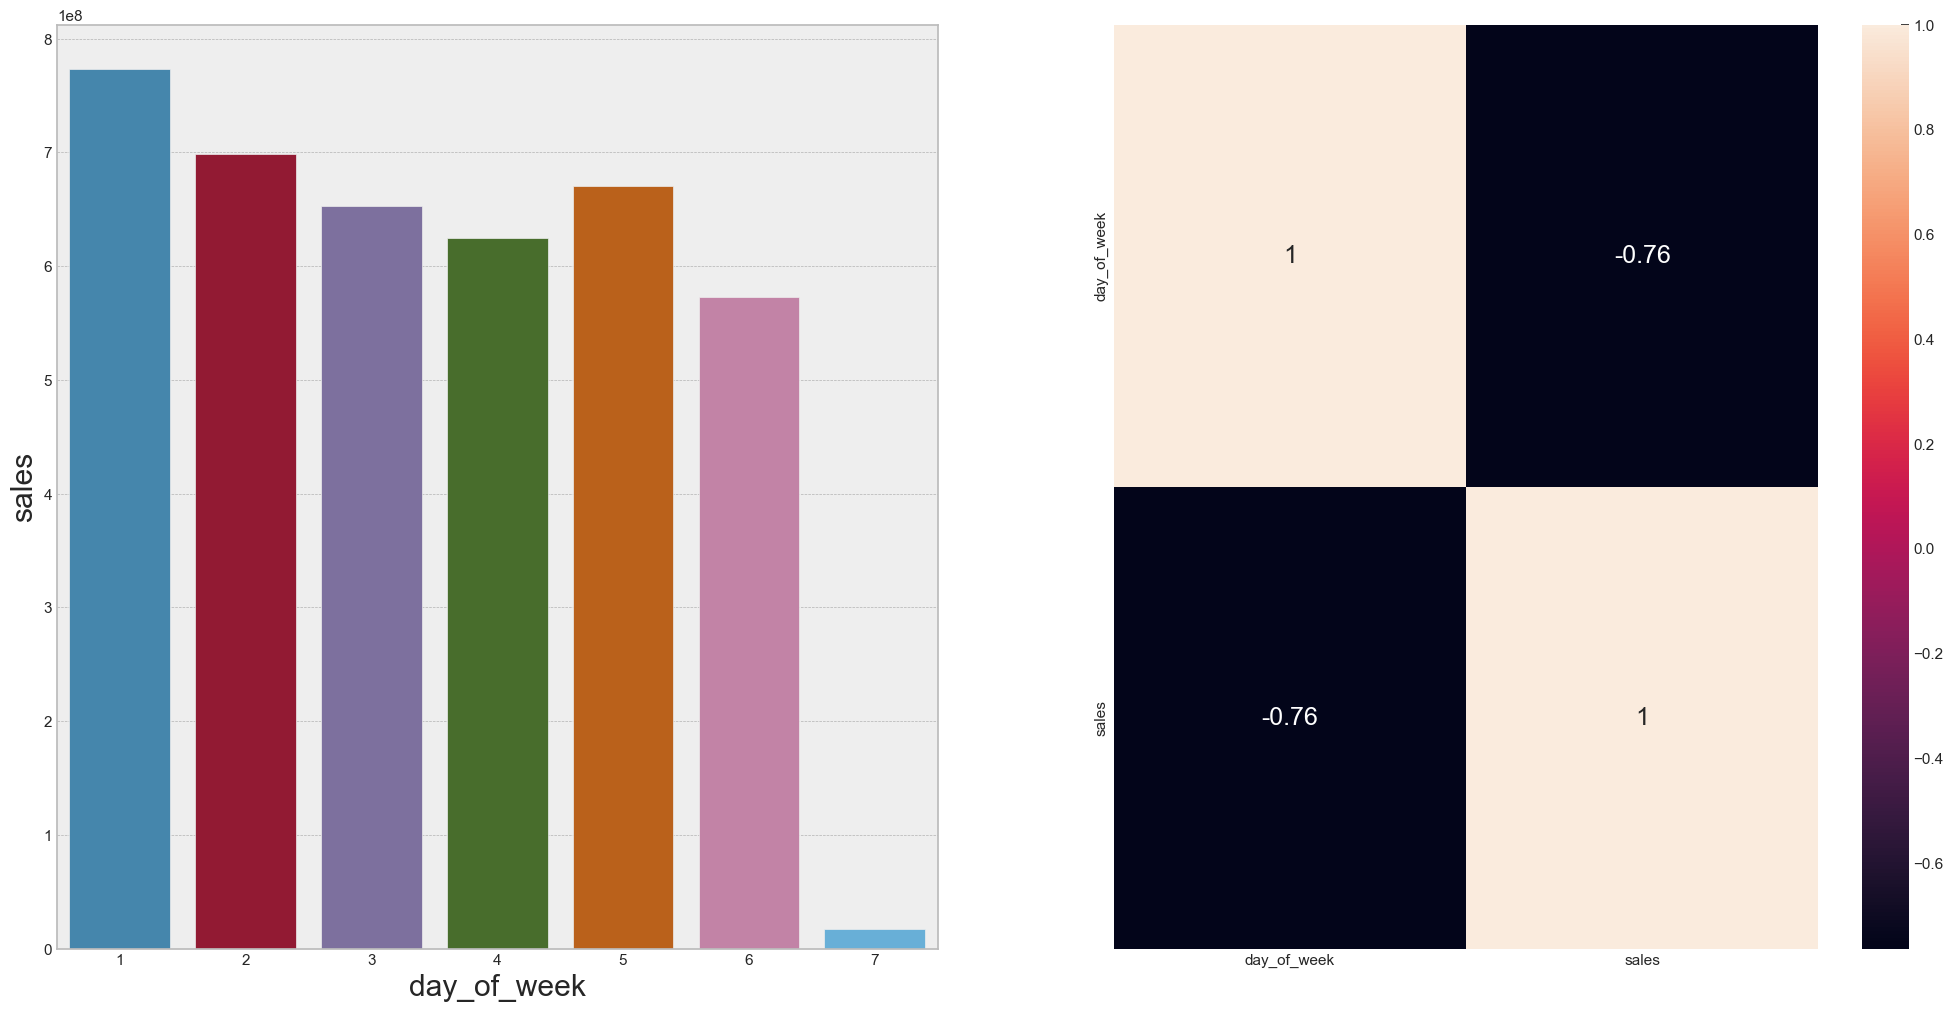

In [41]:
aux1= df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x= 'day_of_week',y='sales',data=aux1);

plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'),annot=True);


### H**13.** Lojas deveriam vender menos durante o feriado escolar
**VERDADEIRO** Lojas VENDEM MENOS durante o feriado escolar, EXCETO julho e Agosto

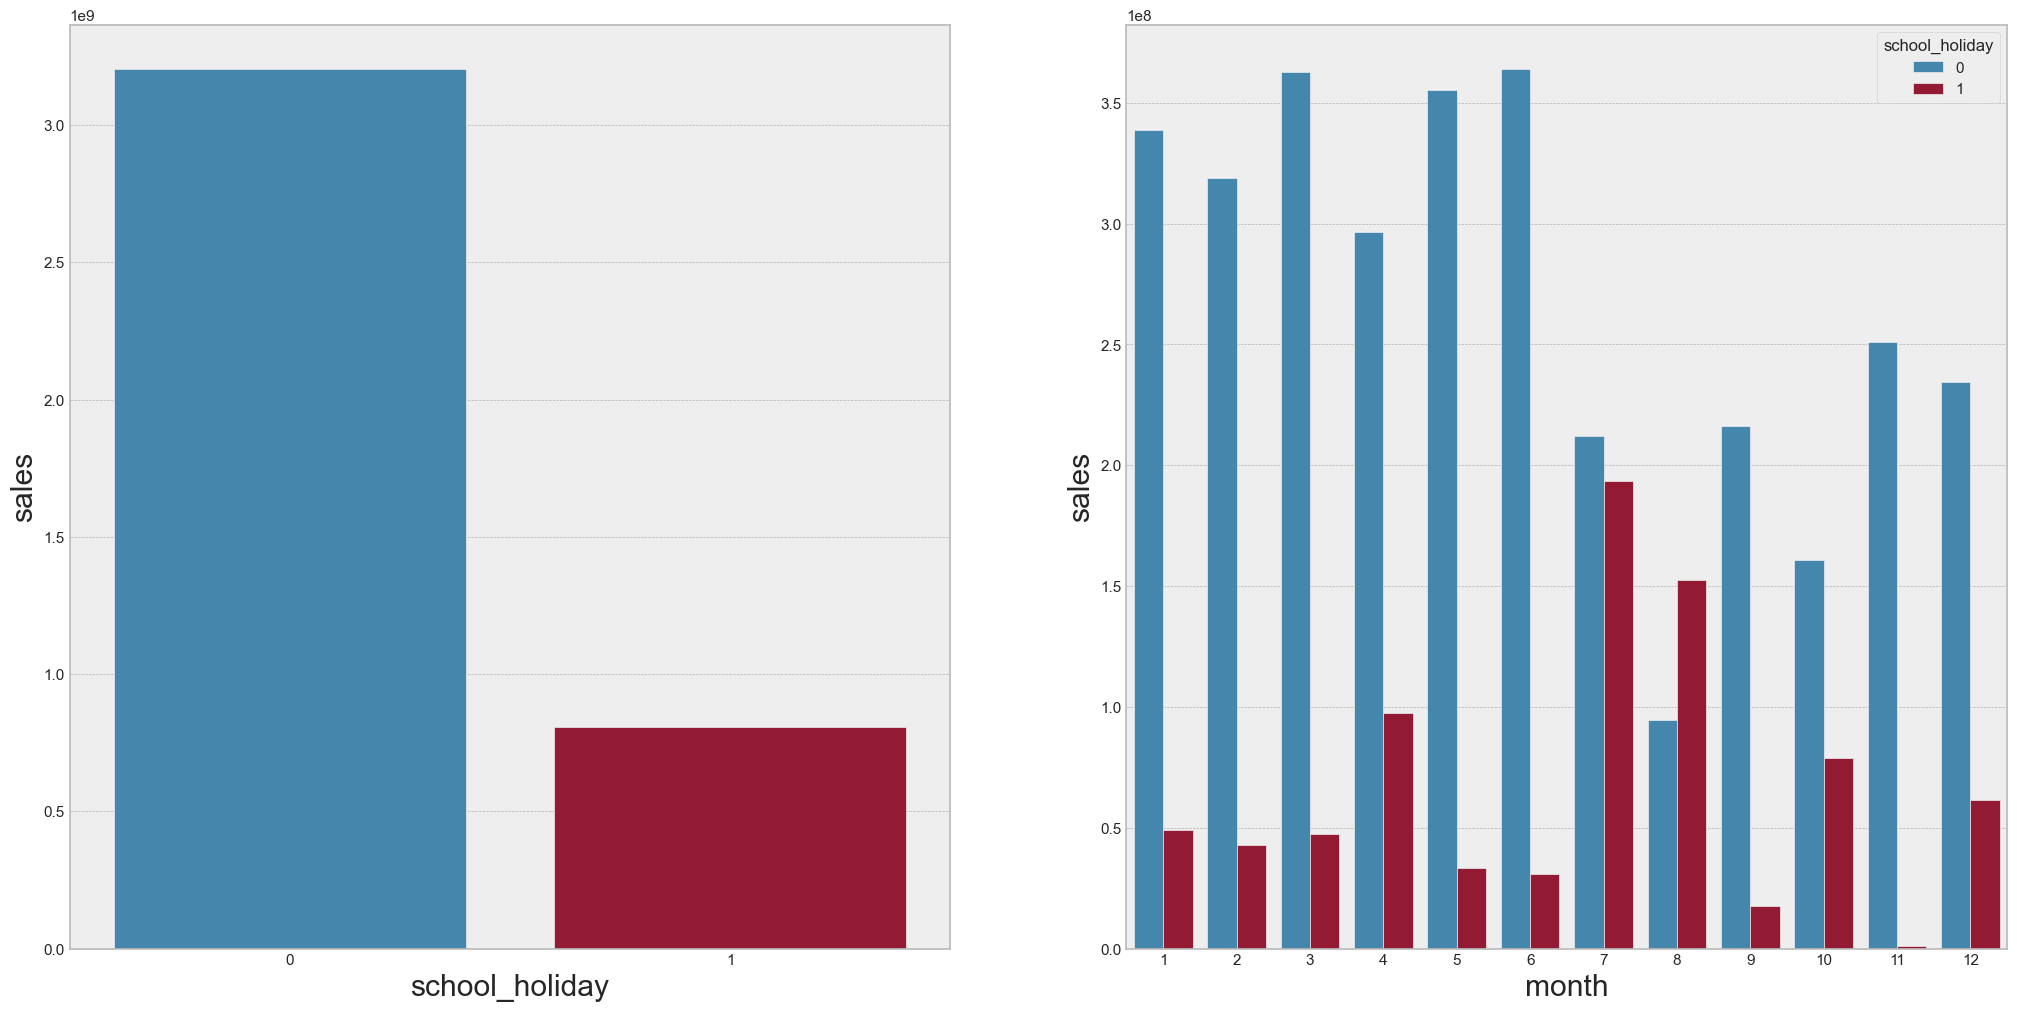

In [42]:
aux1=df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='school_holiday',y='sales',data=aux1);

plt.subplot(1,2,2)
aux2=df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux2);

## 4.3 Multivariate Analysis

### 4.3.1 Numeric Attributes

<AxesSubplot:>

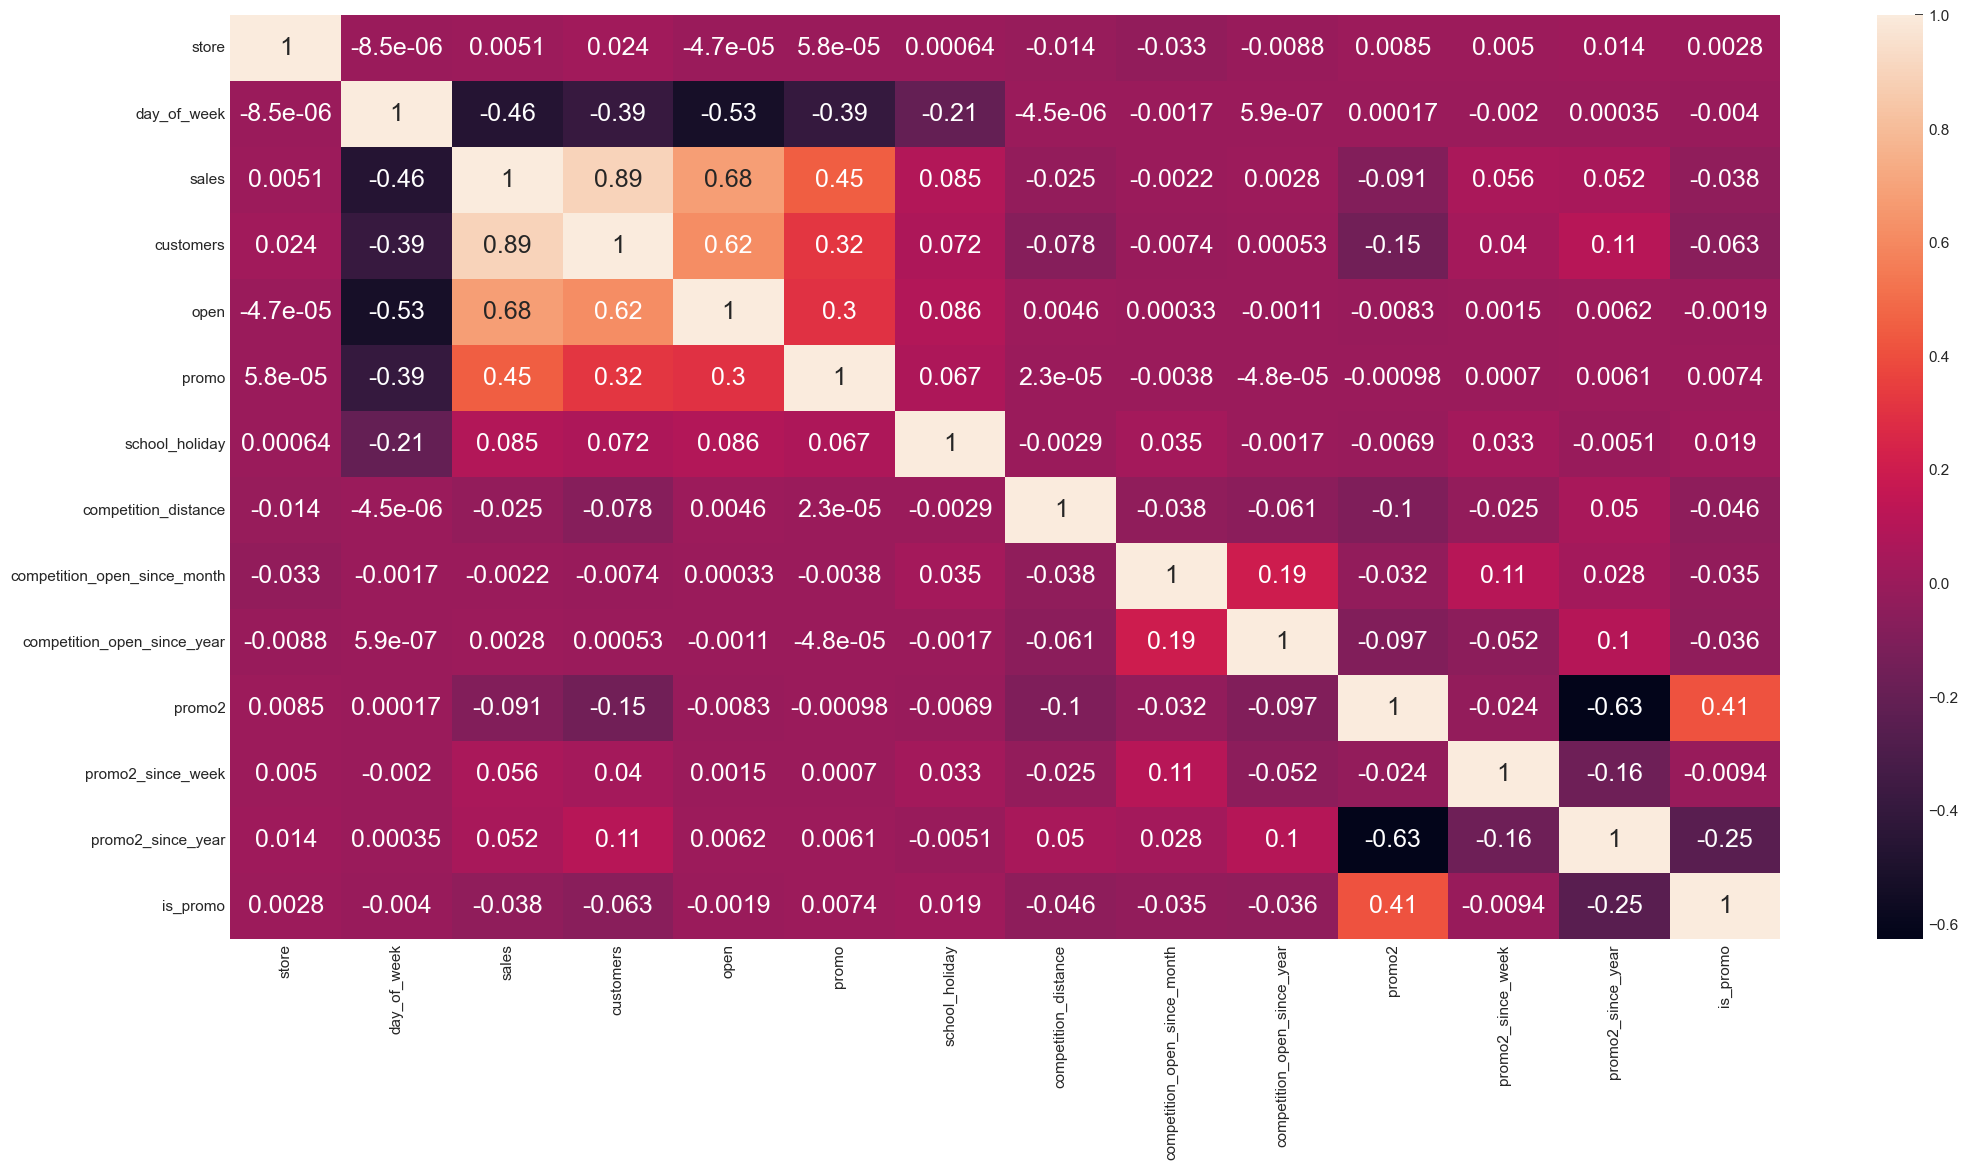

In [43]:
correlation= num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot= True)

### 4.3.2 Categorical Attributes

<AxesSubplot:>

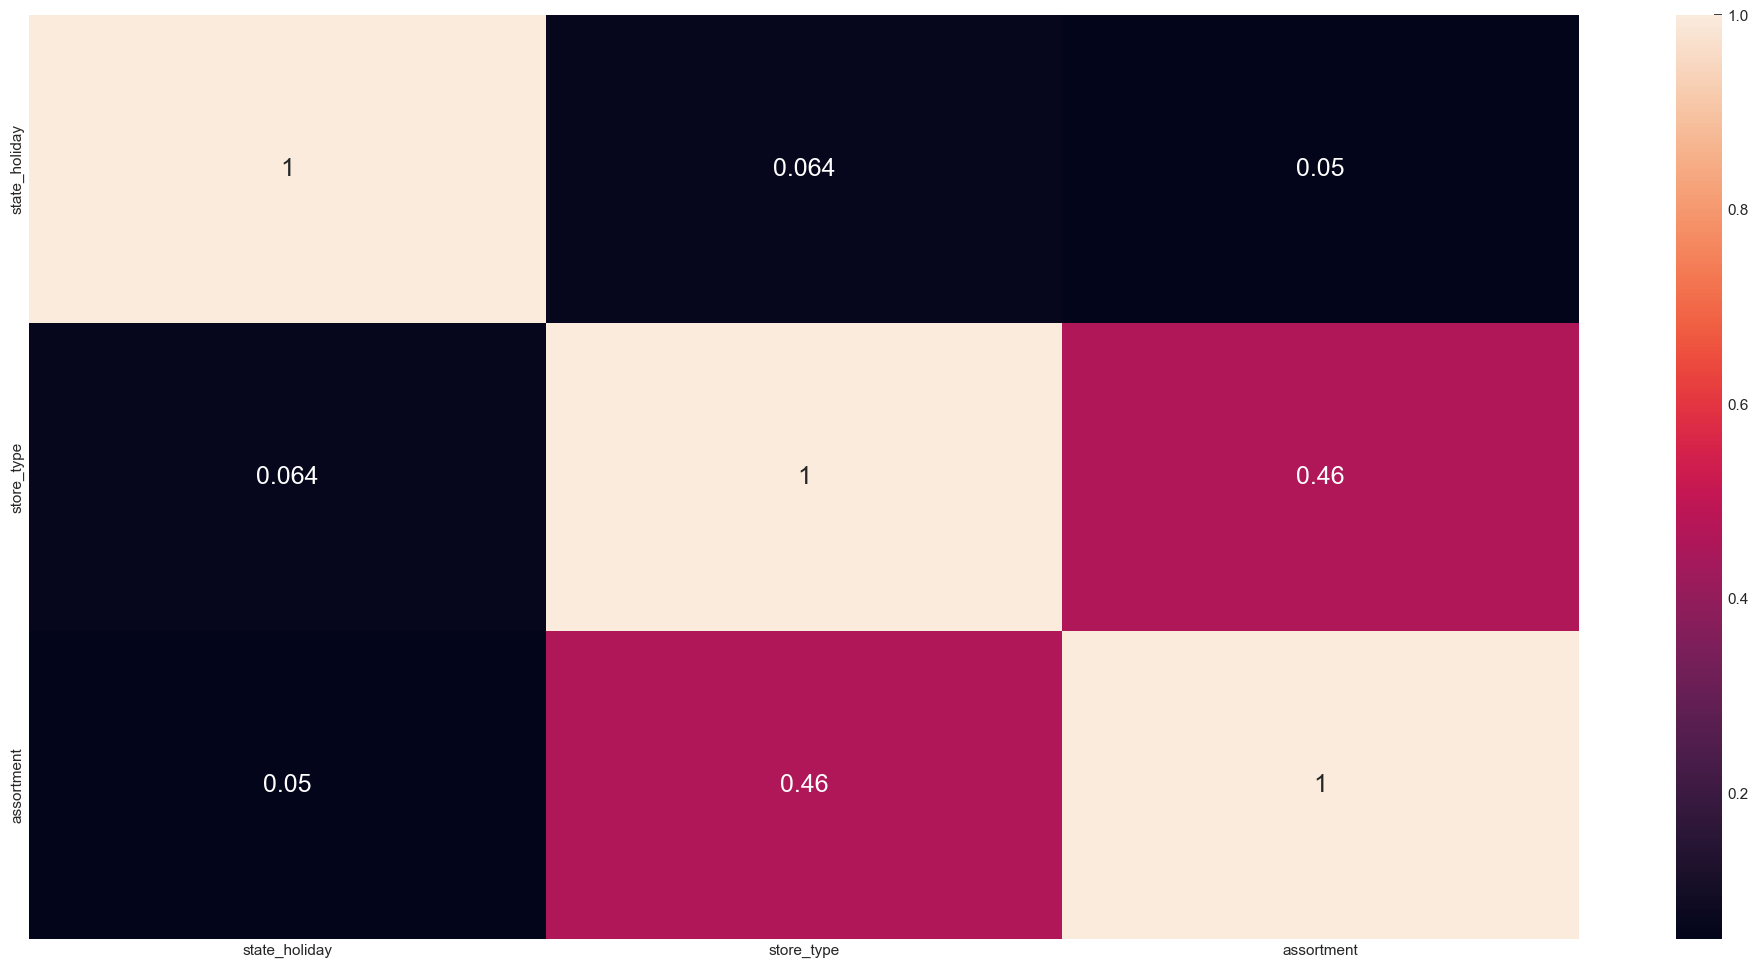

In [77]:
#only categorical data
a=df4.select_dtypes(include='object')

# calculate cramer
a1= cramer_v(a['state_holiday'],a['state_holiday'])
a2= cramer_v(a['state_holiday'],a['store_type'])
a3= cramer_v(a['state_holiday'],a['assortment'])

a4= cramer_v(a['store_type'],a['state_holiday'])
a5= cramer_v(a['store_type'],a['store_type'])
a6= cramer_v(a['store_type'],a['assortment'])

a7= cramer_v(a['assortment'],a['state_holiday'])
a8= cramer_v(a['assortment'],a['store_type'])
a9= cramer_v(a['assortment'],a['assortment'])

d=pd.DataFrame({'state_holiday': [a1,a2,a3],
             'store_type': [a4,a5,a6],
             'assortment': [a7,a8,a9]})

#Final dataset
d = d.set_index(d.columns)

sns.heatmap(d,annot=True)